# 1. 환경 설정 및 라이브러리 Import

In [ ]:
# ======================================================================
#  OHT & AGV 통합 열화 예측 — MultiModal Transformer (MMT) 구현
#
#  목적: 제조 현장 내 이송 장비(OHT, AGV)의 열화 상태를
#        열화상 이미지 + 센서 시계열 데이터로 예측하는 멀티모달 모델 구현.
#
#  데이터: AI Hub "지능형 물류 반송 장비 고장 예지 데이터"
#         - OHT 및 AGV 전체 장비 통합 사용
#         - 8종 센서(PM10/PM2.5/PM1.0/NTC/CT1~4) + 120x160 열화상 바이너리 이미지
#         - 4등급 라벨: 0(정상), 1(주의), 2(경고), 3(위험)
#
#  모델 구성:
#    DL — MMT-S (Multimodal Transformer Small)
#         * 센서 임베딩에 1D-CNN을 적용하여 국소적 시간 패턴(Rolling) 사전 추출
#
#  평가: RMSE(회귀), Macro F1, Macro Recall
#  분할: 장비 단위(Device ID) 기준 Train 70% / Val 15% / Test 15% (Data Leakage 원천 차단)
# ======================================================================

# -- 기본 라이브러리 --
import os, glob, json, time, math, pickle, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from tqdm.auto import tqdm

# -- PyTorch --
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.models as tv_models

# -- scikit-learn (전처리 및 평가) --
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    f1_score, recall_score, mean_squared_error,
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
)

warnings.filterwarnings('ignore')

# ======================================================================
#  GPU 확인
# ======================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"✅ GPU: {gpu_name} ({gpu_mem:.1f} GB)")
else:
    print("⚠️ GPU 미감지 — CPU 모드")

# ======================================================================
#  wandb (Weights & Biases)
#
#  wandb가 하는 일:
#    - 학습 중 loss, lr, F1 등 메트릭을 실시간으로 웹 대시보드에 기록
#    - 모델별 하이퍼파라미터와 성능을 한눈에 비교
#    - confusion matrix, gradient 등을 자동 시각화
#
#  Colab Secrets에 WANDB_API_KEY 저장 필요:
#    좌측 🔑 아이콘 -> WANDB_API_KEY -> wandb.ai에서 발급받은 키 입력
# ======================================================================

import wandb
from google.colab import userdata

try:
    wandb_key = userdata.get('WANDB_API_KEY')
    wandb.login(key=wandb_key)
    WANDB_ENABLED = True
    print("✅ wandb 로그인 성공")
except Exception as e:
    print(f"⚠️ wandb 로그인 실패: {e} — 로컬 로깅만 사용")
    WANDB_ENABLED = False

# ======================================================================
#  캐시 디렉토리
#  시간이 오래 걸리는 작업(압축 해제, 피처 추출, 학습 등)의 결과를
#  pickle/npz 파일로 저장해두고, 재실행 시 즉시 로드하여 시간을 절약
# ======================================================================

CACHE_DIR = '/content/_cache'
os.makedirs(CACHE_DIR, exist_ok=True)

print(f"✅ 환경 설정 완료  |  Device: {device}  |  wandb: {WANDB_ENABLED}")

✅ GPU: NVIDIA A100-SXM4-40GB (39.5 GB)


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kimyeese (kimyeese-sogang-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ wandb 로그인 성공
✅ 환경 설정 완료  |  Device: cuda  |  wandb: True


# 2. Google Drive 마운트 & 데이터 압축 해제 (Training + Validation)

In [ ]:
# ======================================================================
#  Google Drive에서 ZIP 파일을 로컬 디스크로 복사 후 압축 해제
#
#  데이터 구조:
#    Drive/.../Training/01.원천데이터/  -> .bin (열화상 이미지)
#    Drive/.../Training/02.라벨링데이터/ -> .json (센서 + 라벨)
#    Drive/.../Validation/01.원천데이터/ -> .bin
#    Drive/.../Validation/02.라벨링데이터/ -> .json
#
#  로컬 저장 경로:
#    /content/training/source/   -> Training BIN 파일들
#    /content/training/label/    -> Training JSON 파일들
#    /content/validation/source/ -> Validation BIN 파일들
#    /content/validation/label/  -> Validation JSON 파일들
#
#  왜 로컬로 복사하는가:
#    Drive에서 직접 ZIP 해제하면 I/O 병목으로 매우 느림.
#    ZIP을 로컬(/content)로 먼저 복사 후 해제하면 좀 더 빠름.
# ======================================================================

from google.colab import drive
import zipfile, shutil

drive.mount('/content/drive')

# -- 경로 설정 --
data_path = '/content/drive/MyDrive/Degradation_Transport_Dataset/3.개방데이터/1.데이터'

# Training: OHT 01~16번 장비 데이터 (학습 + 검증용)
base_path_train      = os.path.join(data_path, 'Training')
source_zip_dir_train = os.path.join(base_path_train, '01.원천데이터')
label_zip_dir_train  = os.path.join(base_path_train, '02.라벨링데이터')

# Validation: OHT 17~18번 장비 데이터 (최종 테스트용)
base_path_val        = os.path.join(data_path, 'Validation')
source_zip_dir_val   = os.path.join(base_path_val, '01.원천데이터')
label_zip_dir_val    = os.path.join(base_path_val, '02.라벨링데이터')

# 로컬 저장 경로
local_train_source = '/content/training/source'
local_train_label  = '/content/training/label'
local_val_source   = '/content/validation/source'
local_val_label    = '/content/validation/label'
local_zip_cache    = '/content/_zip_cache'   # ZIP 임시 복사 폴더


def extract_via_local(zip_dir, extract_to):
    """
    Drive의 ZIP 파일을 로컬로 복사 후 압축 해제.

    과정:
      1. Drive에서 ZIP 파일 목록 확인
      2. 각 ZIP을 로컬 임시 폴더로 복사
      3. 로컬에서 압축 해제 (Drive I/O 병목 회피)
      4. 임시 ZIP 파일 삭제

    Args:
        zip_dir:    Drive 내 ZIP 파일이 있는 디렉토리
        extract_to: 압축 해제할 로컬 디렉토리
    """
    os.makedirs(extract_to, exist_ok=True)
    os.makedirs(local_zip_cache, exist_ok=True)
    zip_files = sorted([f for f in os.listdir(zip_dir) if f.endswith('.zip')])
    print(f"  {len(zip_files)}개 zip 발견 -> 로컬 복사 후 해제")
    for zf in tqdm(zip_files, desc="  Extract"):
        src = os.path.join(zip_dir, zf)       # Drive 경로
        dst = os.path.join(local_zip_cache, zf) # 로컬 임시 경로
        if not os.path.exists(dst):
            shutil.copy2(src, dst)             # Drive -> 로컬 복사
        try:
            with zipfile.ZipFile(dst, 'r') as z:
                z.extractall(extract_to)       # 로컬에서 해제
        except Exception as e:
            print(f"    ⚠️ {zf} 실패: {e}")
    shutil.rmtree(local_zip_cache, ignore_errors=True)  # 임시 ZIP 삭제


def count_files(directory, ext):
    """디렉토리 내 특정 확장자 파일 수 카운트"""
    if os.path.exists(directory):
        return len(glob.glob(os.path.join(directory, f'*.{ext}')))
    return 0

# ======================================================================
#  Training 데이터 압축 해제
#  이미 해제된 경우(파일 수 >= 99,000) 스킵
# ======================================================================

train_bin_count  = count_files(local_train_source, 'bin')
train_json_count = count_files(local_train_label, 'json')

if train_bin_count >= 99000 and train_json_count >= 99000:
    print("✅ [Training] 이미 압축 해제됨 — 스킵")
else:
    print("📦 [Training] 압축 해제 시작...")
    extract_via_local(source_zip_dir_train, local_train_source)
    extract_via_local(label_zip_dir_train, local_train_label)
    train_bin_count  = count_files(local_train_source, 'bin')
    train_json_count = count_files(local_train_label, 'json')
    print("  ✅ Training 압축 해제 완료!")

print(f"  Training BIN:  {train_bin_count:,}개")
print(f"  Training JSON: {train_json_count:,}개")

# ======================================================================
#  Validation 데이터 압축 해제
#  이미 해제된 경우(파일 수 >= 10,000) 스킵
# ======================================================================

val_bin_count  = count_files(local_val_source, 'bin')
val_json_count = count_files(local_val_label, 'json')

if val_bin_count >= 10000 and val_json_count >= 10000:
    print("\n✅ [Validation] 이미 압축 해제됨 — 스킵")
else:
    print("\n📦 [Validation] 압축 해제 시작...")
    extract_via_local(source_zip_dir_val, local_val_source)
    extract_via_local(label_zip_dir_val, local_val_label)
    val_bin_count  = count_files(local_val_source, 'bin')
    val_json_count = count_files(local_val_label, 'json')
    print("  ✅ Validation 압축 해제 완료!")

print(f"  Validation BIN:  {val_bin_count:,}개")
print(f"  Validation JSON: {val_json_count:,}개")

print(f"\n✅ 전체 데이터: BIN {train_bin_count + val_bin_count:,}개, "
      f"JSON {train_json_count + val_json_count:,}개")

Mounted at /content/drive
📦 [Training] 압축 해제 시작...
  303개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/303 [00:00<?, ?it/s]

  303개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/303 [00:00<?, ?it/s]

  ✅ Training 압축 해제 완료!
  Training BIN:  99,476개
  Training JSON: 99,476개

📦 [Validation] 압축 해제 시작...
  38개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/38 [00:00<?, ?it/s]

  38개 zip 발견 -> 로컬 복사 후 해제


  Extract:   0%|          | 0/38 [00:00<?, ?it/s]

  ✅ Validation 압축 해제 완료!
  Validation BIN:  12,394개
  Validation JSON: 12,394개

✅ 전체 데이터: BIN 111,870개, JSON 111,870개


# 3. JSON 파싱 및 OHT 필터링(X)

In [ ]:
import os
import glob
import json
import pandas as pd
import numpy as np
from tqdm import tqdm

# ======================================================================
#  JSON 라벨 파일 파싱 (OHT + AGV 통합)
#
#  각 JSON 파일에는 다음 정보가 포함되어 있음:
#    meta_info  -> device_id (장비 ID, 예: "oht01", "agv05")
#    sensor_data -> PM10, PM2.5, PM1.0, NTC, CT1~CT4 (8종 센서)
#    annotations -> tagging -> state (열화 등급: 0, 1, 2, 3)
#
#  결과: DataFrame (df_all) — OHT 및 AGV 전체 시점 데이터 병합본
# ======================================================================

# 각 subset별 source/label 경로 매핑
SUBSET_DIRS = {
    'Training': {
        'source': '/content/training/source',
        'label':  '/content/training/label',
    },
    'Validation': {
        'source': '/content/validation/source',
        'label':  '/content/validation/label',
    },
}

CACHE_DIR = './cache' # 캐시 디렉토리 정의 (필요시 수정)
os.makedirs(CACHE_DIR, exist_ok=True)

# 통합용 캐시 파일 이름으로 변경
CACHE_DF = os.path.join(CACHE_DIR, 'df_all_mixed.pkl')

# 4등급 라벨 매핑 (논문 기준)
STATE_MAP = {0: 'Normal', 1: 'Caution', 2: 'Warning', 3: 'Danger'}

# 센서 컬럼명
sensor_cols = ['PM10', 'PM2_5', 'PM1_0', 'NTC', 'CT1', 'CT2', 'CT3', 'CT4']

# ======================================================================
#  캐시 존재 시 로드
# ======================================================================

if os.path.exists(CACHE_DF):
    df_all = pd.read_pickle(CACHE_DF)
    print(f"✅ 통합 캐시에서 로드: {CACHE_DF}")

else:
    def parse_json(filepath, source_dir, subset_name):
        with open(filepath, 'r', encoding='utf-8') as f:
            d = json.load(f)

        meta   = d.get('meta_info', [{}])[0]
        sensor = d.get('sensor_data', [{}])[0]
        anno   = d.get('annotations', [{}])[0]

        # 장비 ID를 대문자로 통일 (예: oht01 -> OHT01, agv05 -> AGV05)
        device_id = str(meta.get('device_id', '')).upper()

        def get_val(obj, key):
            v = obj.get(key)
            if isinstance(v, list) and len(v) > 0: v = v[0]
            if isinstance(v, dict): return v.get('value')
            return v

        state = None
        tagging = anno.get('tagging', [{}])
        if isinstance(tagging, list) and len(tagging) > 0:
            state = int(tagging[0].get('state', -1))

        fname = os.path.basename(filepath).replace('.json', '')
        parts = fname.split('_')
        sort_key = '_'.join(parts[1:]) if len(parts) >= 3 else fname

        bin_path = os.path.join(source_dir, fname + '.bin')

        return {
            'filename':  fname,
            'device_id': device_id,
            'sort_key':  sort_key,
            'bin_path':  bin_path,
            'bin_exists': os.path.exists(bin_path),
            'subset':    subset_name,
            'PM10':  get_val(sensor, 'PM10'),
            'PM2_5': get_val(sensor, 'PM2.5'),
            'PM1_0': get_val(sensor, 'PM1.0'),
            'NTC':   get_val(sensor, 'NTC'),
            'CT1':   get_val(sensor, 'CT1'),
            'CT2':   get_val(sensor, 'CT2'),
            'CT3':   get_val(sensor, 'CT3'),
            'CT4':   get_val(sensor, 'CT4'),
            'state': state,
        }

    records = []
    for subset_name, dirs in SUBSET_DIRS.items():
        label_dir  = dirs['label']
        source_dir = dirs['source']
        json_files = sorted(glob.glob(os.path.join(label_dir, '*.json')))
        print(f"[{subset_name}] JSON 파일: {len(json_files):,}개")

        for fp in tqdm(json_files, desc=f'{subset_name} Parsing'):
            try:
                records.append(parse_json(fp, source_dir, subset_name))
            except:
                pass

    df = pd.DataFrame(records)

    for c in sensor_cols:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    # ⭐ OHT + AGV 전체 데이터 사용
    df_all = df.copy()
    df_all = df_all[df_all['bin_exists']].copy()             # BIN 파일 존재하는 것만
    df_all = df_all.dropna(subset=sensor_cols + ['state'])   # 결측치 제거
    df_all['state'] = df_all['state'].astype(int)

    # 시간순 정렬
    df_all = df_all.sort_values(['device_id', 'sort_key']).reset_index(drop=True)

    # 장비 타입 컬럼 추가 (OHT / AGV)
    df_all['device_type'] = df_all['device_id'].apply(lambda x: 'OHT' if 'OHT' in x else ('AGV' if 'AGV' in x else 'UNKNOWN'))

    df_all.to_pickle(CACHE_DF)
    print(f"\n✅ 통합 캐시 저장 완료: {CACHE_DF}")

# ======================================================================
#  결과 요약 (OHT + AGV)
# ======================================================================

print(f"\n✅ 통합 전체 데이터: {len(df_all):,}건  |  총 장비 수: {df_all['device_id'].nunique()}대")

# 장비 타입별 통계
print("\n[장비 타입별 데이터 건수]")
print(df_all['device_type'].value_counts())

# subset별 통계
for subset in df_all['subset'].unique():
    sub = df_all[df_all['subset'] == subset]
    devices = sorted(sub['device_id'].unique())
    print(f"\n [{subset:10s}] {len(sub):>7,}건  |  장비 수: {len(devices)}대")
    # 출력이 너무 길어질 수 있으므로 장비 ID 목록은 처음 5개만 출력
    print(f"   장비 목록 예시: {devices[:5]} ...")

# 클래스 분포
print(f"\n[클래스 분포]")
for s in sorted(STATE_MAP.keys()):
    c = (df_all['state'] == s).sum()
    print(f"  {STATE_MAP[s]:10s}: {c:>7,} ({c/len(df_all)*100:.1f}%)")

[Training] JSON 파일: 99,476개


Training Parsing: 100%|██████████| 99476/99476 [00:08<00:00, 12250.70it/s]


[Validation] JSON 파일: 12,394개


Validation Parsing: 100%|██████████| 12394/12394 [00:01<00:00, 12265.57it/s]



✅ 통합 캐시 저장 완료: ./cache/df_all_mixed.pkl

✅ 통합 전체 데이터: 111,870건  |  총 장비 수: 36대

[장비 타입별 데이터 건수]
device_type
OHT    66391
AGV    45479
Name: count, dtype: int64

 [Training  ]  99,476건  |  장비 수: 32대
   장비 목록 예시: ['AGV01', 'AGV02', 'AGV03', 'AGV04', 'AGV05'] ...

 [Validation]  12,394건  |  장비 수: 4대
   장비 목록 예시: ['AGV17', 'AGV18', 'OHT17', 'OHT18'] ...

[클래스 분포]
  Normal    :  54,928 (49.1%)
  Caution   :  24,081 (21.5%)
  Danger    :   8,670 (7.8%)


# 4. 에피소드 기반 슬라이딩 윈도우 + 장비 기반 Train/Val/Test 분할

In [ ]:
import os
import pickle
import numpy as np
from tqdm import tqdm

# ======================================================================
#  슬라이딩 윈도우 생성 (OHT + AGV 통합)
#
#  논문 방식: 연속 30개 타임스텝(약 30초)을 하나의 입력으로 묶음.
#
#  [중요] 에피소드 경계 (시간 갭 방어)
#    장비가 멈췄다가 다시 움직일 때의 10초 이상 갭은 별도 에피소드로 분리
#
#  [중요] 장비 기반 분할 (Data Leakage 완전 차단)
#    OHT와 AGV 각각에서 Train/Val/Test 장비 리스트를 명확히 분리하여,
#    "한 번도 보지 못한 장비(Unseen device)"에 대한 일반화 성능을 평가함.
# ======================================================================

WINDOW_SIZE = 30    # 30개 타임스텝 = 약 30초
WINDOW_STEP = 1     # 1 스텝씩 슬라이딩

# OHT+AGV 통합용 캐시 이름 변경
CACHE_WINDOWS = os.path.join(CACHE_DIR, f'windows_mixed_w{WINDOW_SIZE}_s{WINDOW_STEP}.pkl')
CACHE_SPLIT   = os.path.join(CACHE_DIR, f'split_mixed_w{WINDOW_SIZE}_s{WINDOW_STEP}.pkl')

if os.path.exists(CACHE_WINDOWS) and os.path.exists(CACHE_SPLIT):
    with open(CACHE_WINDOWS, 'rb') as f:
        windows = pickle.load(f)
    with open(CACHE_SPLIT, 'rb') as f:
        split_data = pickle.load(f)
        train_windows = split_data['train']
        val_windows   = split_data['val']
        test_windows  = split_data['test']
    print(f"✅ 통합 윈도우 캐시 로드: 총 {len(windows):,}개")
    print(f"   Train: {len(train_windows):,}  |  Val: {len(val_windows):,}  |  Test: {len(test_windows):,}")

else:
    def identify_episodes(group, max_gap_seconds=10):
        """시간 갭 10초 이상이면 새로운 에피소드로 분리"""
        episodes = []
        current_ep = [0]
        for i in range(1, len(group)):
            prev_key = group.iloc[i-1]['sort_key']
            curr_key = group.iloc[i]['sort_key']
            try:
                def to_seconds(key):
                    parts = key.split('_')
                    if len(parts) >= 2:
                        t = parts[1]
                        h, m, s = int(t[:2]), int(t[2:4]), int(t[4:6])
                        d = parts[0]
                        day = int(d[:2]) * 30 + int(d[2:4])
                        return day * 86400 + h * 3600 + m * 60 + s
                    return 0
                gap = abs(to_seconds(curr_key) - to_seconds(prev_key))
                if gap > max_gap_seconds:
                    episodes.append(current_ep)
                    current_ep = [i]
                else:
                    current_ep.append(i)
            except:
                current_ep.append(i)
        if current_ep:
            episodes.append(current_ep)
        return episodes

    def create_windows_by_episode(df, window_size=30, step=1):
        """에피소드 경계를 존중하는 통합 슬라이딩 윈도우 생성"""
        all_windows = []
        ep_counter = 0

        for dev_id, group in tqdm(df.groupby('device_id'), desc='통합 윈도우 생성'):
            group = group.sort_values('sort_key').reset_index(drop=True)
            sensor_arr = group[sensor_cols].values.astype(np.float32)
            labels     = group['state'].values
            bin_paths  = group['bin_path'].values

            # 장비 타입 추출 (OHT_01 -> OHT, AGV_01 -> AGV)
            device_type = dev_id.split('_')[0] if '_' in dev_id else 'UNKNOWN'
            subset     = group['subset'].iloc[0]

            episodes = identify_episodes(group)

            for ep_indices in episodes:
                if len(ep_indices) < window_size:
                    continue
                for start_pos in range(0, len(ep_indices) - window_size + 1, step):
                    idx_slice = ep_indices[start_pos : start_pos + window_size]
                    end_idx = idx_slice[-1]
                    all_windows.append({
                        'sensor':     sensor_arr[idx_slice],    # [30, 8]
                        'bin_path':   bin_paths[end_idx],
                        'label':      float(labels[end_idx]),
                        'label_cls':  int(labels[end_idx]),
                        'device_id':  dev_id,                   # 예: 'OHT_01', 'AGV_05'
                        'device_type': device_type,             # 'OHT' 또는 'AGV'
                        'subset':     subset,
                        'episode_id': ep_counter,
                    })
                ep_counter += 1

        return all_windows

    # -- 윈도우 생성 실행 --
    # 주의: df_all 변수는 이전 셀에서 OHT와 AGV 데이터를 모두 병합한 DataFrame이어야 합니다.
    print(f"통합 윈도우 생성 중... (window={WINDOW_SIZE}, step={WINDOW_STEP})")
    try:
        windows = create_windows_by_episode(df_all, window_size=WINDOW_SIZE, step=WINDOW_STEP)
    except NameError:
        print("\n[에러] 'df_all' 변수가 정의되지 않았습니다. 이전 셀에서 OHT/AGV 병합을 확인하세요.")
        raise

    # ==========================================================================
    #  장비 기반 리스트 명시적 분할 (OHT/AGV 균형 분배)
    #  - Train: 전체 장비의 ~70%
    #  - Val:   전체 장비의 ~15%
    #  - Test:  전체 장비의 ~15% (Unseen Data)
    # ==========================================================================

    # 전체 고유 장비 목록 추출 및 정렬
    unique_devices = sorted(list(set(w['device_id'] for w in windows)))
    oht_devices = [d for d in unique_devices if 'OHT' in d]
    agv_devices = [d for d in unique_devices if 'AGV' in d]

    # 7:1.5:1.5 비율로 장비 나누기 함수
    def split_devices(device_list):
        n = len(device_list)
        train_end = int(n * 0.7)
        val_end = int(n * 0.85)
        return device_list[:train_end], device_list[train_end:val_end], device_list[val_end:]

    oht_train, oht_val, oht_test = split_devices(oht_devices)
    agv_train, agv_val, agv_test = split_devices(agv_devices)

    train_devices = set(oht_train + agv_train)
    val_devices   = set(oht_val + agv_val)
    test_devices  = set(oht_test + agv_test)

    # 윈도우 분배
    train_windows = [w for w in windows if w['device_id'] in train_devices]
    val_windows   = [w for w in windows if w['device_id'] in val_devices]
    test_windows  = [w for w in windows if w['device_id'] in test_devices]

    # 캐시 저장
    with open(CACHE_WINDOWS, 'wb') as f:
        pickle.dump(windows, f)
    with open(CACHE_SPLIT, 'wb') as f:
        pickle.dump({
            'train': train_windows,
            'val':   val_windows,
            'test':  test_windows,
        }, f)
    print(f"✅ 통합 캐시 저장 완료")

# ======================================================================
#  결과 출력
# ======================================================================

n_episodes = len(set(w['episode_id'] for w in windows))
print(f"\n✅ 총 통합 윈도우: {len(windows):,}  |  에피소드: {n_episodes}")
print(f"   Train: {len(train_windows):,}")
print(f"   Val  : {len(val_windows):,}")
print(f"   Test : {len(test_windows):,}")

# 분할별 클래스 분포
print(f"\n[분할별 클래스 분포 (OHT+AGV 통합)]")
header = f"  {'상태':10s}  {'Train':>8s}  {'Val':>8s}  {'Test':>8s}"
print(header)
print(f"  {'─'*40}")
# STATE_MAP이 정의되어 있다고 가정, 없으면 직접 매핑
state_names = {0: '정상', 1: '주의', 2: '경고', 3: '위험'}
for s in sorted(state_names.keys()):
    tr_c = sum(1 for w in train_windows if w['label_cls'] == s)
    va_c = sum(1 for w in val_windows   if w['label_cls'] == s)
    te_c = sum(1 for w in test_windows  if w['label_cls'] == s)
    print(f"  {state_names[s]:10s}  {tr_c:>8,}  {va_c:>8,}  {te_c:>8,}")

# 분할별 할당된 장비 목록 확인
print("\n[장비 분할 현황 (Data Leakage 방지 확인)]")
for name, ws in [('Train', train_windows), ('Val', val_windows), ('Test', test_windows)]:
    devs = sorted(list(set(w['device_id'] for w in ws)))
    print(f"  {name} ({len(devs)}대): {devs}")

통합 윈도우 생성 중... (window=30, step=1)


통합 윈도우 생성: 100%|██████████| 36/36 [00:10<00:00,  3.55it/s]


✅ 통합 캐시 저장 완료

✅ 총 통합 윈도우: 101,952  |  에피소드: 342
   Train: 68,105
   Val  : 16,938
   Test : 16,909

[분할별 클래스 분포 (OHT+AGV 통합)]
  상태             Train       Val      Test
  ────────────────────────────────────────
  정상            30,620     7,557     6,833
  주의            15,825     3,960     4,296
  경고            15,930     3,981     4,280
  위험             5,730     1,440     1,500

[장비 분할 현황 (Data Leakage 방지 확인)]
  Train (24대): ['AGV01', 'AGV02', 'AGV03', 'AGV04', 'AGV05', 'AGV06', 'AGV07', 'AGV08', 'AGV09', 'AGV10', 'AGV11', 'AGV12', 'OHT01', 'OHT02', 'OHT03', 'OHT04', 'OHT05', 'OHT06', 'OHT07', 'OHT08', 'OHT09', 'OHT10', 'OHT11', 'OHT12']
  Val (6대): ['AGV13', 'AGV14', 'AGV15', 'OHT13', 'OHT14', 'OHT15']
  Test (6대): ['AGV16', 'AGV17', 'AGV18', 'OHT16', 'OHT17', 'OHT18']


# 5. 열화상 이미지 로딩 함수

BIN 포맷 확인: 153,728 bytes, 예상=153,728, 일치=True

NaN/Inf 포함 이미지: 0/2000 (0.0%)
로딩 테스트: shape=torch.Size([1, 224, 224]), 범위=[0.004, 0.996], NaN=False


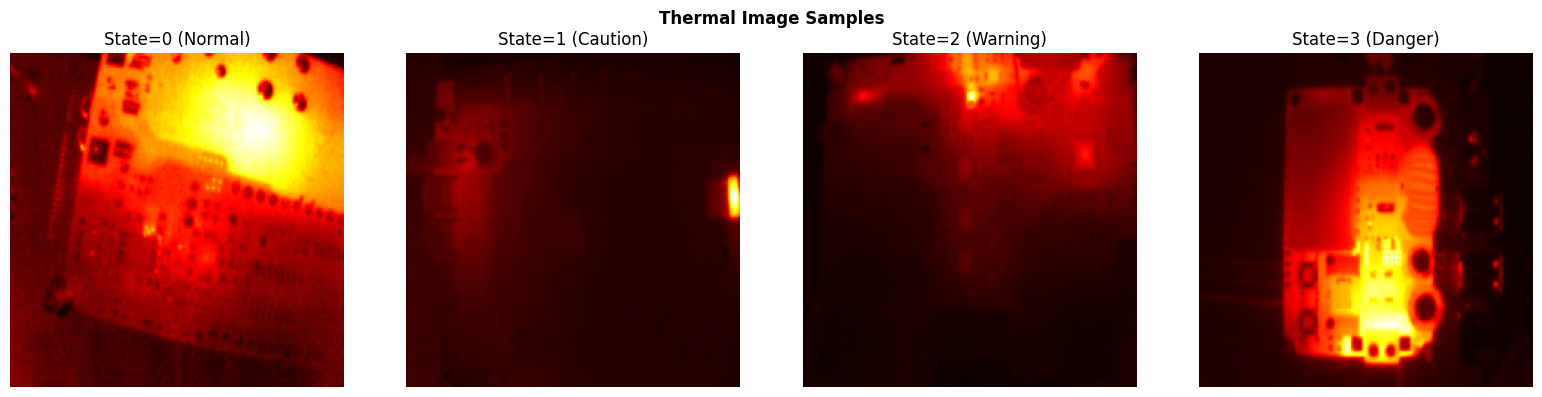

In [ ]:
# ======================================================================
#  BIN 파일 포맷
#
#  구조: [128-byte 헤더] + [120 x 160 float64 픽셀]
#    헤더:  128바이트 (메타데이터, 스킵)
#    픽셀:  120행 x 160열 x 8바이트(float64) = 153,600바이트
#    총합:  128 + 153,600 = 153,728바이트
#
#  각 픽셀 값은 섭씨 온도(℃)를 나타냄 (예: 43.7, 51.2)
#
#  [주의] NaN/Inf 방어
#    실제 BIN 파일 내부에 NaN(Not a Number)과 Inf(무한대)가
#    존재하는 사례가 확인됨 (센서 수집 오류 또는 결측).
#    이를 처리하지 않으면 모델 학습 시 loss가 NaN으로 폭발.
#    -> NaN/Inf를 이미지 중앙값(nanmedian)으로 대체
# ======================================================================

HEADER_SIZE = 128          # BIN 파일 헤더 크기 (바이트)
THERMAL_H, THERMAL_W = 120, 160   # 원본 이미지 해상도
IMG_SIZE = 224             # 모델 입력 크기 (224x224)

# 포맷 확인
sample_bin = windows[0]['bin_path']
file_size = os.path.getsize(sample_bin)
expected_size = HEADER_SIZE + THERMAL_H * THERMAL_W * 8  # float64 = 8 bytes
print(f"BIN 포맷 확인: {file_size:,} bytes, 예상={expected_size:,}, 일치={file_size == expected_size}")


def load_thermal_image(bin_path):
    """
    BIN 파일을 읽어 [1, 224, 224] 텐서로 변환.

    과정:
      1. 128바이트 헤더 스킵
      2. float64로 읽어 120x160 배열 생성
      3. NaN/Inf 값을 이미지 중앙값으로 대체 (안전 처리)
      4. Min-Max 정규화 -> [0, 1] 범위
      5. PIL로 224x224 리사이즈
      6. [1, 224, 224] 텐서 반환

    Args:
        bin_path: BIN 파일 경로

    Returns:
        tensor: [1, 224, 224] float32 텐서 (0~1 범위)
                실패 시 전체 0 텐서 반환
    """
    try:
        raw = np.fromfile(bin_path, dtype=np.uint8)
        data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
        img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)

        # NaN/Inf 방어: 유한하지 않은 값을 중앙값으로 대체
        if not np.all(np.isfinite(img)):
            median_val = np.nanmedian(img)
            if np.isnan(median_val):
                median_val = 0.0
            img = np.where(np.isfinite(img), img, median_val)

        # Min-Max 정규화
        vmin, vmax = img.min(), img.max()
        if vmax > vmin:
            img = (img - vmin) / (vmax - vmin)
        else:
            img = np.zeros_like(img)

        # 224x224 리사이즈
        pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
        pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
        tensor = torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0)
        return tensor.unsqueeze(0)    # [1, 224, 224]
    except:
        return torch.zeros(1, IMG_SIZE, IMG_SIZE)


# ======================================================================
#  NaN/Inf 오염 통계 확인
#  데이터 중 몇 %의 이미지에 NaN/Inf가 포함되어 있는지 확인
# ======================================================================

nan_count = 0
check_n = min(2000, len(windows))
for i in range(check_n):
    try:
        raw = np.fromfile(windows[i]['bin_path'], dtype=np.uint8)
        data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
        img = data.reshape(THERMAL_H, THERMAL_W)
        if not np.all(np.isfinite(img)):
            nan_count += 1
    except:
        pass
print(f"\nNaN/Inf 포함 이미지: {nan_count}/{check_n} ({nan_count/check_n*100:.1f}%)")

# 로딩 테스트
test_img = load_thermal_image(windows[0]['bin_path'])
print(f"로딩 테스트: shape={test_img.shape}, "
      f"범위=[{test_img.min():.3f}, {test_img.max():.3f}], "
      f"NaN={torch.isnan(test_img).any().item()}")

# 시각화: 4개 샘플 열화상 이미지
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, idx in enumerate([0, len(windows)//3, len(windows)*2//3, len(windows)-1]):
    img = load_thermal_image(windows[idx]['bin_path'])
    axes[i].imshow(img.squeeze(), cmap='hot')
    axes[i].set_title(f"State={windows[idx]['label_cls']} ({STATE_MAP[windows[idx]['label_cls']]})")
    axes[i].axis('off')
plt.suptitle('Thermal Image Samples', fontweight='bold')
plt.tight_layout()
plt.show()

# 6. DL Dataset & DataLoader

In [ ]:
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

# ======================================================================
#  이 셀에서 하는 일 (DL 전용, OHT+AGV 통합 데이터셋):
#    1. DL 모델(MMT-S + 1D CNN)용 범용 PyTorch Dataset 정의
#       * OHT 및 AGV 장비 데이터를 모두 처리 가능
#       * 1D CNN 입력을 위해 센서 차원 [30, 8] -> [8, 30] 변환 포함
#    2. Train / Val / Test DataLoader 생성
# ======================================================================

# (이전에 정의되어야 할 변수들 - 코드 문맥상 가정)
# IMG_SIZE = 224, THERMAL_H = ..., THERMAL_W = ..., HEADER_SIZE = ...
# train_windows, val_windows, test_windows (OHT/AGV 필터링 없이 전체 사용)

class MultimodalSensorDataset(Dataset):
    """
    통합 멀티모달 Dataset: 센서 시계열 + 열화상 이미지.
    OHT(천장반송설비) 및 AGV(무인운반차) 데이터 모두 호환.

    특징:
      - 센서 정규화: Train의 mean/std로 Z-score 정규화 (Val/Test에도 동일 적용)
      - 차원 변환: 1D-CNN 입력 호환을 위해 센서 텐서를 [8, 30]으로 변환 (Channel-First)
      - 이미지 로딩: _load_image 함수로 NaN/Inf 방어 + Min-Max 정규화
      - 센서 NaN 방어: torch.nan_to_num으로 최종 안전 처리
    """
    def __init__(self, windows, sensor_mean=None, sensor_std=None, fit_scaler=False):
        self.windows = windows
        all_sensors = np.stack([w['sensor'] for w in windows])

        if fit_scaler:
            # Train 데이터에서 센서 통계 계산
            self.sensor_mean = all_sensors.reshape(-1, 8).mean(axis=0)
            self.sensor_std  = all_sensors.reshape(-1, 8).std(axis=0) + 1e-8
        else:
            # Val/Test는 Train의 통계 사용
            self.sensor_mean = sensor_mean
            self.sensor_std  = sensor_std

    def __len__(self):
        return len(self.windows)

    def _load_image(self, bin_path):
        """BIN -> [1, 224, 224] 텐서 (NaN/Inf 방어 포함)"""
        try:
            raw = np.fromfile(bin_path, dtype=np.uint8)
            data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
            img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)

            # NaN/Inf 방어
            if not np.all(np.isfinite(img)):
                med = np.nanmedian(img)
                if np.isnan(med): med = 0.0
                img = np.where(np.isfinite(img), img, med)

            vmin, vmax = img.min(), img.max()
            if vmax > vmin:
                img = (img - vmin) / (vmax - vmin)
            else:
                img = np.zeros_like(img)

            pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
            pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            tensor = torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0)
            return tensor.unsqueeze(0) # [1, 224, 224]
        except:
            return torch.zeros(1, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        w = self.windows[idx]

        # 1. 센서 Z-score 정규화 + NaN 안전 처리
        sensor_norm = (w['sensor'] - self.sensor_mean) / self.sensor_std
        sensor = torch.from_numpy(sensor_norm.astype(np.float32))
        sensor = torch.nan_to_num(sensor, nan=0.0, posinf=3.0, neginf=-3.0)

        # ★ 핵심: 1D-CNN을 위해 [30, 8] -> [8, 30] 으로 축 변경 (Channel First)
        sensor = sensor.transpose(0, 1)

        # 2. 이미지 로드 (NaN 방어 내장)
        image = self._load_image(w['bin_path'])

        # 3. 라벨 (장비 종류 무관하게 열화 상태 라벨 반환)
        label_reg = torch.tensor(w['label'], dtype=torch.float32)
        label_cls = torch.tensor(w['label_cls'], dtype=torch.long)

        return sensor, image, label_reg, label_cls


# ======================================================================
#  DL DataLoader 생성
# ======================================================================

# Train: scaler fit (이 데이터에서 센서 mean/std 계산)
train_dataset = MultimodalSensorDataset(train_windows, fit_scaler=True)

# Val/Test: Train의 통계 사용
val_dataset = MultimodalSensorDataset(
    val_windows,
    sensor_mean=train_dataset.sensor_mean,
    sensor_std=train_dataset.sensor_std,
)
test_dataset = MultimodalSensorDataset(
    test_windows,
    sensor_mean=train_dataset.sensor_mean,
    sensor_std=train_dataset.sensor_std,
)

BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=0, pin_memory=True, drop_last=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=0, pin_memory=True)

# 배치 확인 + NaN 검증
sensor_batch, image_batch, label_reg, label_cls = next(iter(train_loader))

print(f"\n✅ 통합 DL 데이터 준비 완료 (OHT + AGV, 1D-CNN 호환 형태)")
print(f"  [배치 확인] Sensor: {sensor_batch.shape}, Image: {image_batch.shape}")
print(f"  Sensor NaN: {torch.isnan(sensor_batch).any().item()}")
print(f"  Image  NaN: {torch.isnan(image_batch).any().item()}")
print(f"  Label  NaN: {torch.isnan(label_reg).any().item()}")

print(f"  Train: {len(train_dataset):>6,} -> {len(train_loader):>4} batches")
print(f"  Val:   {len(val_dataset):>6,} -> {len(val_loader):>4} batches")
print(f"  Test:  {len(test_dataset):>6,} -> {len(test_loader):>4} batches")


✅ 통합 DL 데이터 준비 완료 (OHT + AGV, 1D-CNN 호환 형태)
  [배치 확인] Sensor: torch.Size([32, 8, 30]), Image: torch.Size([32, 1, 224, 224])
  Sensor NaN: False
  Image  NaN: False
  Label  NaN: False
  Train: 68,105 -> 2128 batches
  Val:   16,938 ->  530 batches
  Test:  16,909 ->  529 batches


# 8. DL 모델 정의

In [ ]:
import torch
import torch.nn as nn

# ==============================================================================
#  4. MMT — MultiModal Transformer (논문의 핵심 제안 모델 개선판)
# ==============================================================================
#
#  [개선점: 1D-CNN 센서 임베딩 적용]
#    기존: 센서 데이터를 nn.Linear로 1초 단위로 독립 임베딩 (Local Temporal Pattern 무시)
#    개선: nn.Conv1d(kernel_size=3)을 사용하여 직전/직후 초를 포함한 슬라이딩 윈도우
#          (Rolling statistics) 패턴을 트랜스포머 어텐션 이전에 스스로 학습하도록 유도.
#          파라미터 증가는 0.5% 미만으로 억제하면서 OHT+AGV 통합 데이터의 예측력 극대화.
#
#  [개선점: 회귀 헤드 안정화]
#    최종 출력단(Regression Head)에 BatchNorm1d 및 강화된 Dropout을 적용하여
#    제조 현장 노이즈 데이터에 대한 과적합(Overfitting)을 방지.
# ==============================================================================

class MultimodalTransformer(nn.Module):
    """
    개선된 MMT (Multimodal Transformer) 구현.

    이미지 패치 토큰(196) + 1D-CNN 센서 시계열 토큰(30) + [CLS](1) = 227 토큰을
    단일 Transformer Encoder에서 전역 Self-Attention으로 처리.

    입력:
        sensor: [B, 8, 30]       -- 센서 시계열 (Dataset에서 Channel-First 변환됨)
        image:  [B, 1, 224, 224] -- 열화상 이미지 (grayscale)
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=1,
                 sensor_seq_len=30, sensor_dim=8,
                 d_model=128, nhead=4, num_layers=4, d_ff=512, dropout=0.1):
        super().__init__()
        self.d_model    = d_model
        self.patch_size = patch_size

        # 패치 수: (224 / 16)^2 = 14^2 = 196
        num_patches = (img_size // patch_size) ** 2     # 196
        patch_dim = in_channels * patch_size ** 2       # 256
        self.num_patches = num_patches

        # Image Patch Embedding (ViT 방식)
        self.patch_embed = nn.Linear(patch_dim, d_model)

        # 학습 가능한 이미지 공간 위치 임베딩
        self.img_pos_embed = nn.Parameter(
            torch.randn(1, num_patches, d_model) * 0.02
        )

        # ⭐ 개선된 Sensor Embedding: 1D-CNN 기반 국소적 시간 패턴 추출기
        # 입력 형태: [B, sensor_dim(8), seq_len(30)]
        self.sensor_embed = nn.Sequential(
            nn.Conv1d(in_channels=sensor_dim, out_channels=d_model,
                      kernel_size=3, padding=1),
            nn.GELU(),
            nn.BatchNorm1d(d_model) # 시계열 피처 정규화
        )

        # 학습 가능한 센서 시간 위치 임베딩
        self.sensor_pos_embed = nn.Parameter(
            torch.randn(1, sensor_seq_len, d_model) * 0.02
        )

        # [CLS] Token
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, d_model) * 0.02
        )

        # Transformer Encoder (Pre-LN 구조 유지)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,            # 토큰 임베딩 차원
            nhead=nhead,                # 멀티헤드 수
            dim_feedforward=d_ff,       # FFN 중간 차원
            dropout=dropout,            # Attention/FFN dropout
            activation='gelu',          # FFN 활성화
            batch_first=True,           # [B, T, D] 형태
            norm_first=True,            # Pre-LayerNorm
        )
        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )

        self.norm = nn.LayerNorm(d_model)

        # ⭐ 개선된 회귀 Head: BatchNorm 및 Dropout 추가로 과적합 방어
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.BatchNorm1d(d_model // 2), # 추가된 배치 정규화
            nn.GELU(),
            nn.Dropout(p=0.3),            # 강화된 Dropout 비율
            nn.Linear(d_model // 2, 1),
        )

    def _patchify(self, images):
        """ [B, 1, 224, 224] -> [B, 196, 256] """
        B, C, H, W = images.shape
        p = self.patch_size
        x = images.unfold(2, p, p).unfold(3, p, p)       # [B, C, 14, 14, 16, 16]
        x = x.contiguous().view(B, C, -1, p, p)          # [B, C, 196, 16, 16]
        x = x.permute(0, 2, 1, 3, 4).contiguous()        # [B, 196, C, 16, 16]
        return x.view(B, self.num_patches, -1)           # [B, 196, 256]

    def forward(self, sensor, image):
        """
        Args:
            sensor: [B, 8, 30]       -- 1D-CNN 대응 형태로 입력됨
            image:  [B, 1, 224, 224] -- 열화상 이미지

        Returns:
            pred: [B] -- 열화 상태 회귀값 (0~3)
        """
        B = sensor.shape[0]

        # Step 1: Image -> 196 patch tokens
        patches = self._patchify(image)                         # [B, 196, 256]
        img_tokens = self.patch_embed(patches)                  # [B, 196, d_model]
        img_tokens = img_tokens + self.img_pos_embed            # + 공간 위치

        # Step 2: Sensor -> 30 sequence tokens (⭐ 1D-CNN 적용)
        # sensor 입력 형태: [B, 8, 30] -> Conv1d 통과 -> [B, d_model(128), 30]
        sen_tokens_cnn = self.sensor_embed(sensor)

        # Transformer 입력을 위해 Sequence가 두 번째 차원으로 오도록 Transpose
        # [B, d_model, 30] -> [B, 30, d_model]
        sen_tokens = sen_tokens_cnn.transpose(1, 2)
        sen_tokens = sen_tokens + self.sensor_pos_embed         # + 시간 위치

        # Step 3: Concat [CLS] + Image + Sensor
        cls = self.cls_token.expand(B, -1, -1)                  # [B, 1, d_model]
        tokens = torch.cat([cls, img_tokens, sen_tokens], dim=1)
        # tokens: [B, 227, d_model]

        # Step 4: Transformer Encoder (전역 Self-Attention)
        out = self.transformer(tokens)                          # [B, 227, d_model]

        # Step 5: [CLS] -> regression
        cls_out = self.norm(out[:, 0, :])                       # [B, d_model]
        return self.head(cls_out).squeeze(-1)                   # [B]


# ==============================================================================
#  모델 등록 — 논문 성능 검증용 단일 모델 구성
# ==============================================================================

dl_model_configs = {
    'MMT-S (CNN-Embed)': {
        'class':       MultimodalTransformer,
        'kwargs':      {'d_model': 128, 'nhead': 4, 'num_layers': 4, 'd_ff': 512},
        'category':    '멀티모달 (개선판)',
        'description': 'MMT Small + 1D-CNN 임베딩 + 융합 Dataset',
    }
}

# -- 모델 요약 출력 --
print(f"{'='*75}")
print(f"  DL Models Summary (OHT+AGV 통합 & 1D-CNN 롤링 추출기 적용)")
print(f"{'='*75}")
print(f"  {'모델':20s} {'카테고리':14s} {'파라미터':>12s}   설명")
print(f"  {'─'*70}")
for name, cfg in dl_model_configs.items():
    m = cfg['class'](**cfg['kwargs'])
    n_params = sum(p.numel() for p in m.parameters())
    print(f"  {name:20s} {cfg['category']:14s} {n_params:>12,}   {cfg['description']}")
    del m
print(f"{'='*75}")

  DL Models Summary (OHT+AGV 통합 & 1D-CNN 롤링 추출기 적용)
  모델                   카테고리                   파라미터   설명
  ──────────────────────────────────────────────────────────────────────
  MMT-S (CNN-Embed)    멀티모달 (개선판)          867,201   MMT Small + 1D-CNN 임베딩 + 융합 Dataset


# 9. DL 학습/평가 함수

In [ ]:
# ======================================================================
#  wandb 프로젝트 설정
# ======================================================================

WANDB_PROJECT = 'MMT-OHT-Degradation'
WANDB_ENTITY  = None    # 개인 계정이면 None, 팀이면 팀명

def init_wandb_run(model_name, model, config_extra=None):
    """
    모델별 wandb run 초기화.

    wandb run 1개 = 모델 1개의 전체 학습 과정.
    모델명, 하이퍼파라미터, 데이터 크기 등을 config로 기록.
    """
    if not WANDB_ENABLED:
        return None

    n_params = sum(p.numel() for p in model.parameters())
    cfg = dl_model_configs.get(model_name, {})

    config = {
        'model_name':   model_name,
        'category':     cfg.get('category', 'Unknown'),
        'n_params':     n_params,
        'num_epochs':   30,
        'batch_size':   BATCH_SIZE,
        'lr':           1e-5,
        'weight_decay': 1e-2,
        'window_size':  WINDOW_SIZE,
        'window_step':  WINDOW_STEP,
        'train_size':   len(train_dataset),
        'val_size':     len(val_dataset),
        'test_size':    len(test_dataset),
        'optimizer':    'AdamW',
        'scheduler':    'CosineAnnealingWarmup',
        'gpu':          torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU',
    }
    if 'kwargs' in cfg:
        config.update({f'model/{k}': v for k, v in cfg['kwargs'].items()})
    if config_extra:
        config.update(config_extra)

    # 이전 run이 있으면 먼저 종료 (wandb 0.25+ 호환)
    try:
        wandb.finish()
    except:
        pass

    run = wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        name=model_name,
        config=config,
    )
    return run

# ======================================================================
#  학습/평가 함수
# ======================================================================

def train_one_epoch(model, loader, criterion, optimizer, scheduler, device,
                    epoch=None, num_epochs=None, model_name='',
                    wandb_run=None, global_step=0):
    """
    1 에폭 학습.

    tqdm 진행률 표시 + wandb에 배치별 loss/lr 기록 (50 step마다).
    """
    model.train()
    total_loss, n_samples = 0, 0

    desc = f"  [{model_name}] Epoch {epoch}/{num_epochs}" if epoch else "  Training"
    pbar = tqdm(loader, desc=desc, leave=False, bar_format='{l_bar}{bar:30}{r_bar}')

    for sensor, image, label_reg, label_cls in pbar:
        sensor    = sensor.to(device)
        image     = image.to(device)
        label_reg = label_reg.to(device)

        optimizer.zero_grad()
        pred = model(sensor, image)
        loss = criterion(pred, label_reg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        batch_size  = sensor.size(0)
        total_loss += loss.item() * batch_size
        n_samples  += batch_size
        global_step += 1

        # wandb: 50 step마다 배치 loss/lr 기록
        if wandb_run and global_step % 50 == 0:
            wandb_run.log({
                'train/batch_loss': loss.item(),
                'train/lr': optimizer.param_groups[0]['lr'],
                'global_step': global_step,
            }, step=global_step)

        pbar.set_postfix({
            'loss': f'{total_loss / n_samples:.4f}',
            'lr':   f'{optimizer.param_groups[0]["lr"]:.2e}',
        })
    pbar.close()
    return total_loss / n_samples, global_step

def evaluate_dl(model, loader, device):
    """모델 평가 -> RMSE, F1, Recall, 예측값, 실제 라벨"""
    model.eval()
    all_preds, all_labels_reg, all_labels_cls = [], [], []
    with torch.no_grad():
        for sensor, image, label_reg, label_cls in loader:
            pred = model(sensor.to(device), image.to(device))
            all_preds.append(pred.cpu().numpy())
            all_labels_reg.append(label_reg.numpy())
            all_labels_cls.append(label_cls.numpy())
    preds      = np.concatenate(all_preds)
    labels_reg = np.concatenate(all_labels_reg)
    labels_cls = np.concatenate(all_labels_cls)
    rmse     = np.sqrt(np.mean((preds - labels_reg) ** 2))
    pred_cls = np.clip(np.round(preds), 0, 3).astype(int)
    f1       = f1_score(labels_cls, pred_cls, average='macro', zero_division=0)
    recall   = recall_score(labels_cls, pred_cls, average='macro', zero_division=0)
    return rmse, f1, recall, preds, labels_cls

def train_dl_model(name, model, train_loader, val_loader, test_loader, device,
                   num_epochs=30, lr=1e-3):
    """
    DL 모델 전체 학습 파이프라인.

    구성:
      - Loss: MSELoss (회귀)
      - Optimizer: AdamW (weight_decay=1e-2)
      - Scheduler: Cosine Annealing + Linear Warmup (500 steps)
      - Early Stopping: Val F1 기준 Best 모델 저장
      - wandb: epoch별 메트릭 + confusion matrix 자동 업로드

    Args:
        name:         모델 이름 (로그 및 wandb run 이름)
        model:        학습할 모델
        train_loader: 학습 DataLoader (장비 01~14)
        val_loader:   검증 DataLoader (장비 15~16)
        test_loader:  테스트 DataLoader (장비 17~18)
        device:       GPU/CPU
        num_epochs:   총 에폭 수
        lr:           초기 학습률

    Returns:
        dict: model, best_epoch, val/test 메트릭, history
    """
    n_params = sum(p.numel() for p in model.parameters())
    print(f"\n{'='*65}")
    print(f"  Training: {name}")
    print(f"  Params: {n_params:,}  |  Epochs: {num_epochs}  |  LR: {lr}")
    print(f"{'='*65}")

    wandb_run = init_wandb_run(name, model)

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

    # Cosine LR + Warmup
    total_steps  = num_epochs * len(train_loader)
    warmup_steps = min(500, total_steps // 5)

    def lr_lambda(step):
        if step < warmup_steps:
            return step / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    # wandb gradient 감시
    if wandb_run:
        wandb.watch(model, criterion, log='gradients', log_freq=200)

    best_val_f1, best_state = 0, None
    best_val_rmse, best_val_recall, best_epoch = 0, 0, 0
    history = {
        'train_loss': [],
        'val_rmse': [], 'val_f1': [], 'val_recall': [],
        'test_rmse': [], 'test_f1': [], 'test_recall': [],
    }

    global_step = 0
    t0 = time.time()

    for epoch in range(1, num_epochs + 1):
        train_loss, global_step = train_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, device,
            epoch=epoch, num_epochs=num_epochs, model_name=name,
            wandb_run=wandb_run, global_step=global_step,
        )
        val_rmse,  val_f1,  val_recall,  _, _ = evaluate_dl(model, val_loader, device)
        test_rmse, test_f1, test_recall, _, _ = evaluate_dl(model, test_loader, device)

        history['train_loss'].append(train_loss)
        history['val_rmse'].append(val_rmse);     history['val_f1'].append(val_f1)
        history['val_recall'].append(val_recall)
        history['test_rmse'].append(test_rmse);    history['test_f1'].append(test_f1)
        history['test_recall'].append(test_recall)

        # wandb epoch 로깅
        if wandb_run:
            wandb_run.log({
                'epoch': epoch, 'train/epoch_loss': train_loss,
                'val/rmse': val_rmse, 'val/f1': val_f1, 'val/recall': val_recall,
                'test/rmse': test_rmse, 'test/f1': test_f1, 'test/recall': test_recall,
            })

        # Best 저장 (Val F1 기준)
        is_best = val_f1 > best_val_f1
        if is_best:
            best_val_f1, best_val_rmse, best_val_recall = val_f1, val_rmse, val_recall
            best_epoch = epoch
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 5 == 0 or epoch == 1:
            star = '  ★' if is_best else ''
            print(f"  Epoch {epoch:02d}/{num_epochs}: "
                  f"Loss={train_loss:.4f} | "
                  f"Val F1={val_f1:.4f} RMSE={val_rmse:.4f} | "
                  f"Test F1={test_f1:.4f} RMSE={test_rmse:.4f}{star}")

    elapsed = time.time() - t0

    # Best 복원 -> Train + Test 최종 평가
    model.load_state_dict(best_state)
    model = model.to(device)
    train_rmse, train_f1, train_recall, _, _ = evaluate_dl(model, train_loader, device)
    test_rmse, test_f1, test_recall, _, _ = evaluate_dl(model, test_loader, device)

    # wandb summary + confusion matrix
    if wandb_run:
        wandb_run.summary.update({
            'best_epoch': best_epoch, 'best_val_f1': best_val_f1,
            'best_val_rmse': best_val_rmse,
            'final_test_f1': test_f1, 'final_test_rmse': test_rmse,
            'final_test_recall': test_recall, 'training_time': elapsed,
        })
        _, _, _, t_preds, t_labels = evaluate_dl(model, test_loader, device)
        t_pred_cls = np.clip(np.round(t_preds), 0, 3).astype(int)
        wandb_run.log({'test/confusion_matrix': wandb.plot.confusion_matrix(
            probs=None, y_true=t_labels.tolist(), preds=t_pred_cls.tolist(),
            class_names=[STATE_MAP[i] for i in range(4)],
        )})
        wandb.unwatch(model)
        wandb_run.finish()

    print(f"\n  >>> Best @ Epoch {best_epoch}:")
    print(f"      Val:  F1={best_val_f1:.4f}, RMSE={best_val_rmse:.4f}")
    print(f"      Test: F1={test_f1:.4f}, RMSE={test_rmse:.4f}, Recall={test_recall:.4f}")
    print(f"  >>> 소요: {elapsed:.0f}s ({elapsed/60:.1f}min)")

    return {
        'model': model, 'best_epoch': best_epoch,
        'train_rmse': train_rmse, 'train_f1': train_f1, 'train_recall': train_recall,
        'val_rmse': best_val_rmse, 'val_f1': best_val_f1, 'val_recall': best_val_recall,
        'test_rmse': test_rmse, 'test_f1': test_f1, 'test_recall': test_recall,
        'time': elapsed, 'history': history,
    }

print("✅ 학습/평가 함수 정의 완료")

✅ 학습/평가 함수 정의 완료


# 10. DL 모델 학습(MMT-S)

구글 드라이브를 연동(Mount)하고, 드라이브 내 특정 폴더에 각 모델의 .pth 가중치 파일과 전체 결과 피클 파일을 안전하게 영구 저장하도록 코드를 수정

In [ ]:
# 결과를 담을 리스트가 미리 정의되어 있어야 합니다.
if 'all_results' not in locals():
    all_results = []

# 그 다음 기존 코드를 실행하세요.
all_results.append({
    'Category': dl_model_configs['MMT-S (CNN-Embed)']['category'],
    'Model': 'MMT-S (CNN-Embed)',
    'Train RMSE': result['train_rmse'],
    'Train F1': result['train_f1'],
    'Val RMSE': result['val_rmse'],
    'Val F1': result['val_f1'],
    'Test RMSE': result['test_rmse'],
    'Test F1': result['test_f1'],
    'Test Recall': result['test_recall']
})

# 결과 표 출력
# import pandas as pd
# df_res = pd.DataFrame(all_results)
# display(df_res)

,Category,Model,Train RMSE,Train F1,Val RMSE,Val F1,Test RMSE,Test F1,Test Recall
0,멀티모달 (개선판),MMT-S (CNN-Embed),0.124393,0.977785,0.22203,0.939097,0.321768,0.919849,0.91809


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 구글 드라이브 내에 결과를 저장할 폴더 생성 (원하시는 경로로 수정 가능)
DRIVE_SAVE_DIR = '/content/drive/MyDrive/MMT_Project_Models'
os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)

# 피클 파일 경로도 드라이브로 변경
CACHE_DL_RESULTS = os.path.join(DRIVE_SAVE_DIR, 'dl_results_v2.pkl')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ======================================================================
#  7개 DL 모델 순차 학습
#
#  학습 순서: CNN(1ch) -> CNN(3ch) -> LSTM -> CNN+LSTM
#             -> MMT-S -> MMT-B -> MMT-L
#
#  각 모델 학습 후 GPU 메모리 해제
#  전체 결과는 all_results 리스트와 dl_results 딕셔너리에 저장
#  학습 완료 후 캐시로 저장 (재실행 시 즉시 로드)
#
#  [v2 변경] Train 메트릭(RMSE/F1/Recall) 포함
#    -> Cell 11 결과 테이블에서 NaN 없이 출력
# ======================================================================

import os
import torch
import pickle

NUM_EPOCHS = 30
# 앞서 설정한 구글 드라이브 경로 사용
# CACHE_DL_RESULTS = os.path.join(DRIVE_SAVE_DIR, 'dl_results_v2.pkl')

# ======================================================================
#  캐시 존재 시: 구글 드라이브에서 모델과 결과 복원
# ======================================================================

if os.path.exists(CACHE_DL_RESULTS):
    print("🔄 구글 드라이브에서 이전 학습 결과와 가중치를 불러옵니다...")
    with open(CACHE_DL_RESULTS, 'rb') as f:
        cache_dl = pickle.load(f)

    dl_results = {}
    for name, saved in cache_dl.items():
        cfg = dl_model_configs[name]
        model = cfg['class'](**cfg['kwargs'])

        # 모델 가중치 복원 (드라이브에 저장된 .pth 파일 확인)
        model_weights_path = os.path.join(DRIVE_SAVE_DIR, f"{name}_best.pth")
        if os.path.exists(model_weights_path):
            model.load_state_dict(torch.load(model_weights_path))
            print(f"  [{name}] 가중치 로드 완료 (.pth 파일 기반)")
        else:
            # .pth 파일이 없으면 피클 안의 state_dict 사용 (단일모달 등)
            model.load_state_dict(saved['state_dict'])
            print(f"  [{name}] 가중치 로드 완료 (피클 통합 파일 기반)")

        model = model.to(device).eval()

        dl_results[name] = {
            'model': model, 'best_epoch': saved['best_epoch'],
            'train_rmse': saved['train_rmse'], 'train_f1': saved['train_f1'],
            'train_recall': saved['train_recall'],
            'val_rmse': saved['val_rmse'], 'val_f1': saved['val_f1'],
            'val_recall': saved['val_recall'],
            'test_rmse': saved['test_rmse'], 'test_f1': saved['test_f1'],
            'test_recall': saved['test_recall'],
            'time': saved['time'], 'history': saved['history'],
        }

    # all_results에 추가 (중복 방지)
    existing_models = {r['Model'] for r in all_results}
    for name, res in dl_results.items():
        if name not in existing_models:
            all_results.append({
                'Category': dl_model_configs[name]['category'], 'Model': name,
                'Train RMSE': res['train_rmse'], 'Train F1': res['train_f1'],
                'Train Recall': res['train_recall'],
                'Val RMSE': res['val_rmse'], 'Val F1': res['val_f1'],
                'Val Recall': res['val_recall'],
                'Test RMSE': res['test_rmse'], 'Test F1': res['test_f1'],
                'Test Recall': res['test_recall'],
                'Time(s)': res['time'],
            })

    print(f"\n✅ DL 결과 캐시 로드 + 모델 복원: {len(dl_results)}개")
    for name, res in dl_results.items():
        print(f"  {name:12s}: Train F1={res['train_f1']:.4f}, "
              f"Val F1={res['val_f1']:.4f}, Test F1={res['test_f1']:.4f}")

# ======================================================================
#  캐시 없을 시: 전체 학습 실행 및 구글 드라이브 영구 저장
# ======================================================================

else:
    print(f"{'='*70}")
    print(f"  DL Models Training ({len(dl_model_configs)} models x {NUM_EPOCHS} epochs)")
    print(f"  Train: {len(train_dataset):,} | Val: {len(val_dataset):,} | Test: {len(test_dataset):,}")
    print(f"{'='*70}")

    dl_results = {}

    # ★ .pth 파일로 별도 저장할 타겟 모델 리스트
    TARGET_SAVE_MODELS = ['CNN+LSTM', 'MMT-S', 'My_MMT']

    for name, cfg in dl_model_configs.items():
        print(f"\n🚀 모델 학습 시작: {name} ...")
        model = cfg['class'](**cfg['kwargs'])

        result = train_dl_model(
            name, model,
            train_loader, val_loader, test_loader,
            device, num_epochs=NUM_EPOCHS, lr=1e-3,
        )
        dl_results[name] = result

        # 지정된 타겟 모델만 .pth 파일로 개별 저장
        if name in TARGET_SAVE_MODELS:
            model_weights_path = os.path.join(DRIVE_SAVE_DIR, f"{name}_best.pth")
            torch.save(result['model'].state_dict(), model_weights_path)
            print(f"💾 [{name}] 가중치 개별 저장 완료: {model_weights_path}")

        all_results.append({
            'Category': cfg['category'], 'Model': name,
            'Train RMSE': result['train_rmse'], 'Train F1': result['train_f1'],
            'Train Recall': result['train_recall'],
            'Val RMSE': result['val_rmse'], 'Val F1': result['val_f1'],
            'Val Recall': result['val_recall'],
            'Test RMSE': result['test_rmse'], 'Test F1': result['test_f1'],
            'Test Recall': result['test_recall'],
            'Time(s)': result['time'],
        })
        del model
        torch.cuda.empty_cache()

    # 전체 결과 메타데이터 캐시 저장 (모든 모델의 CPU state_dict 포함)
    cache_save = {}
    for name, res in dl_results.items():
        cache_save[name] = {
            'state_dict': {k: v.cpu() for k, v in res['model'].state_dict().items()},
            'best_epoch': res['best_epoch'],
            'train_rmse': res['train_rmse'], 'train_f1': res['train_f1'],
            'train_recall': res['train_recall'],
            'val_rmse': res['val_rmse'], 'val_f1': res['val_f1'],
            'val_recall': res['val_recall'],
            'test_rmse': res['test_rmse'], 'test_f1': res['test_f1'],
            'test_recall': res['test_recall'],
            'time': res['time'], 'history': res['history'],
        }
    with open(CACHE_DL_RESULTS, 'wb') as f:
        pickle.dump(cache_save, f)
    print(f"\n✅ 전체 DL 학습 완료 & 구글 드라이브 저장 완료!")

  DL Models Training (1 models x 30 epochs)
  Train: 68,105 | Val: 16,938 | Test: 16,909

🚀 모델 학습 시작: MMT-S (CNN-Embed) ...

  Training: MMT-S (CNN-Embed)
  Params: 867,201  |  Epochs: 30  |  LR: 0.001


  Epoch 01/30: Loss=0.2244 | Val F1=0.8511 RMSE=0.3279 | Test F1=0.8358 RMSE=0.4223  ★


  Epoch 05/30: Loss=0.0874 | Val F1=0.9185 RMSE=0.2451 | Test F1=0.9010 RMSE=0.3509  ★


  Epoch 10/30: Loss=0.0704 | Val F1=0.9174 RMSE=0.2466 | Test F1=0.8953 RMSE=0.3494


  Epoch 15/30: Loss=0.0578 | Val F1=0.9247 RMSE=0.2424 | Test F1=0.9050 RMSE=0.3420


  Epoch 20/30: Loss=0.0467 | Val F1=0.9320 RMSE=0.2299 | Test F1=0.9125 RMSE=0.3280


  Epoch 25/30: Loss=0.0397 | Val F1=0.9390 RMSE=0.2203 | Test F1=0.9200 RMSE=0.3167  ★


  Epoch 30/30: Loss=0.0351 | Val F1=0.9390 RMSE=0.2220 | Test F1=0.9183 RMSE=0.3231


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
global_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█████
test/f1,▁▄▃▅▆▇▆▇▇▆▆█▇█▇▇█▇█▇██████████
test/recall,▁▅▂▆▆▇▆▇▇▆▆███▇▇█▇█▇██▇▇██████
test/rmse,█▇▅▅▃▄▃▃▂▃▃▁▂▂▃▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train/batch_loss,█▃▆▃▅▃▃▃▄▃▄▃▄█▅▁▃▅▂▃▄▂▃▂▂▃▂▂▂▃▁▃▂▃▂▃▁▂▁▂
train/epoch_loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train/lr,█████████▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁
val/f1,▁▅▂▆▆▇▆▇█▆▆█▇▇▇██▇▇▇██████████
val/recall,▁▆▂▆▆▇▆▇▇▆▆█▇█▇▇█▇█▇██▇███████
+1,...



  >>> Best @ Epoch 28:
      Val:  F1=0.9391, RMSE=0.2220
      Test: F1=0.9198, RMSE=0.3218, Recall=0.9181
  >>> 소요: 3659s (61.0min)


NameError: name 'all_results' is not defined

In [ ]:
import torch
import os
from google.colab import drive

# 1. 구글 드라이브 마운트
drive.mount('/content/drive')

# 2. 폴더 경로 설정 (내 드라이브의 MMT_trial_1)
target_dir = '/content/drive/MyDrive/MMT_trial_1/'

# 3. 폴더가 없으면 새로 생성
if not os.path.exists(target_dir):
    os.makedirs(target_dir)
    print(f"📂 새 폴더를 생성했습니다: {target_dir}")
else:
    print(f"✅ 기존 폴더를 확인했습니다: {target_dir}")

# 4. 저장할 모델 이름과 경로 설정
target_model_name = 'MMT-S (CNN-Embed)'
save_path = os.path.join(target_dir, 'MMT-S_CNN-Embed_best.pth')

# 5. dl_results에서 모델을 가져와 저장
if target_model_name in dl_results:
    model_state = dl_results[target_model_name]['model'].state_dict()
    torch.save(model_state, save_path)
    print(f"🚀 [저장 완료] 모델이 다음 경로에 저장되었습니다:")
    print(f"📍 {save_path}")
else:
    # 만약 dl_results 이름이 다를 경우를 대비해 현재 메모리의 best_dl_model이라도 저장
    try:
        torch.save(best_dl_model.state_dict(), save_path)
        print(f"🚀 [강제 저장 완료] 메모리 내 모델을 {save_path}에 저장했습니다.")
    except NameError:
        print(f"❌ 저장 실패: 메모리에 '{target_model_name}' 모델이 없습니다.")

# 6. 파일이 잘 들어갔는지 확인
!ls -lh "{target_dir}"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 새 폴더를 생성했습니다: /content/drive/MyDrive/MMT_trial_1/
🚀 [저장 완료] 모델이 다음 경로에 저장되었습니다:
📍 /content/drive/MyDrive/MMT_trial_1/MMT-S_CNN-Embed_best.pth
total 3.4M
-rw------- 1 root root 3.4M Feb 23 08:43 MMT-S_CNN-Embed_best.pth


# 11. 종합 결과 비교 & 시각화

In [ ]:
import os
import glob

print(f"📁 현재 설정된 캐시 폴더 경로: {CACHE_DIR}")
print("-" * 50)

# 1. 폴더 자체가 존재하는지 확인
if not os.path.exists(CACHE_DIR):
    print("🚨 앗! 캐시 폴더 자체가 사라졌습니다. (코랩 런타임 초기화 의심)")
else:
    # 2. 폴더 안의 모든 파일 출력
    files = os.listdir(CACHE_DIR)
    if len(files) == 0:
        print("🚨 폴더는 있지만 안이 텅텅 비어있습니다!")
    else:
        print(f"✅ 총 {len(files)}개의 캐시 파일이 발견되었습니다:\n")
        for f in sorted(files):
            # 파일 크기도 같이 확인 (너무 작으면 껍데기일 수 있음)
            f_path = os.path.join(CACHE_DIR, f)
            size_mb = os.path.getsize(f_path) / (1024 * 1024)
            print(f"  - {f} ({size_mb:.2f} MB)")

📁 현재 설정된 캐시 폴더 경로: ./cache
--------------------------------------------------
✅ 총 3개의 캐시 파일이 발견되었습니다:

  - df_all_mixed.pkl (18.59 MB)
  - split_mixed_w30_s1.pkl (105.68 MB)
  - windows_mixed_w30_s1.pkl (105.68 MB)


 🚀 MMT-S (CNN-Embed) Performance Report
 [Ours MMT-S (CNN-Embed)]
   - Test Macro F1  : 0.9198
   - Test RMSE      : 0.3218

 [1. Comparison with Paper MMT (논문)]
   - F1 Improvement :  +0.0254
   - RMSE Diff      :  +0.0343

 [2. Comparison with Ours Baseline MMT-S (기존)]
   - F1 Improvement :  +0.0064
   - RMSE Reduction :  +0.0260 (Positive is Better)


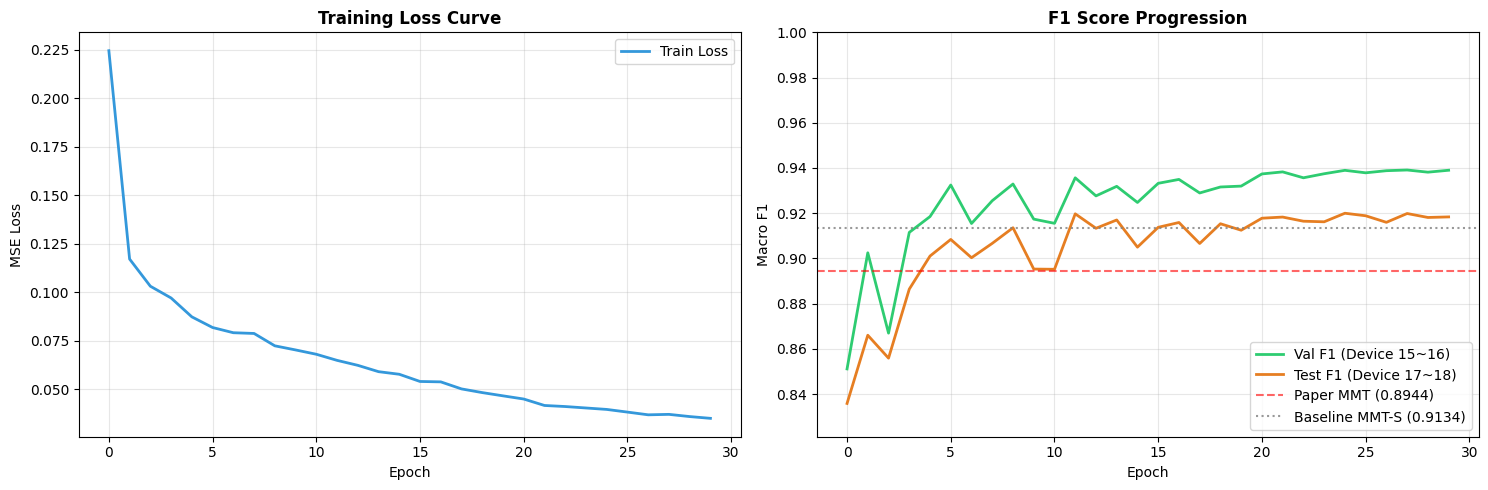

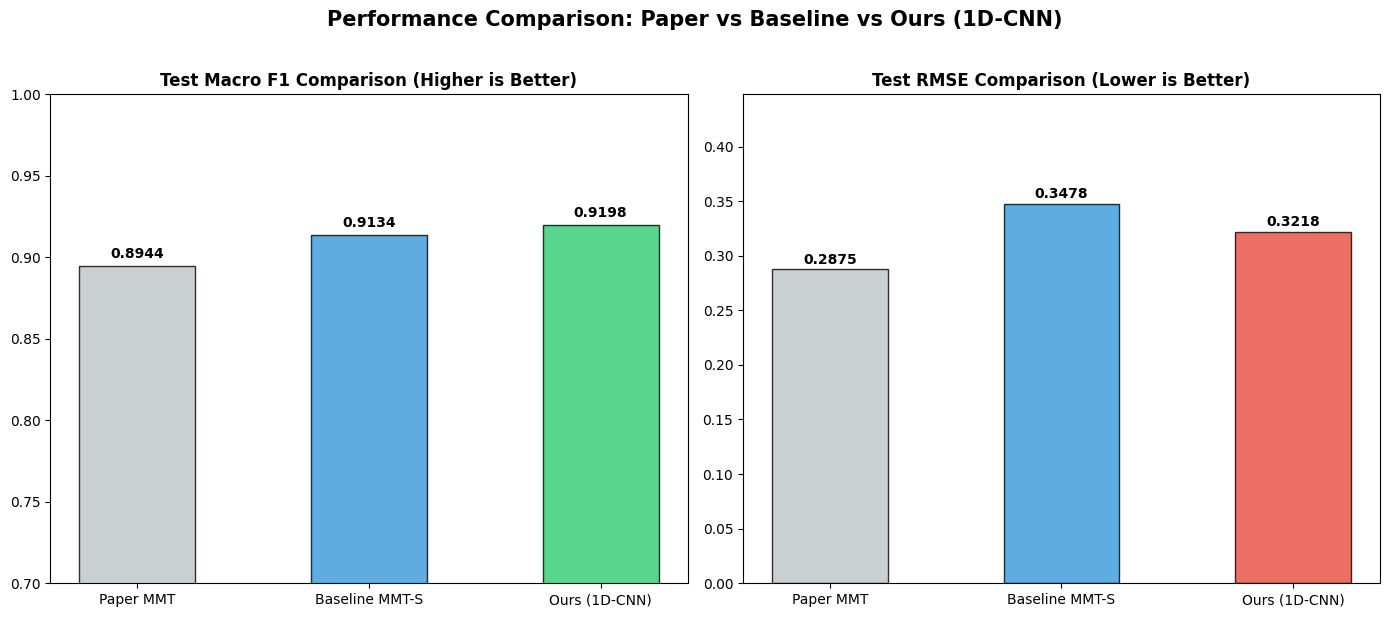

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. 결과 추출
target_model = 'MMT-S (CNN-Embed)'

# 베이스라인 수치 정의 (사용자님이 제공한 테이블 기준)
paper_mmt_f1, paper_mmt_rmse = 0.8944, 0.2875
base_mmt_s_f1, base_mmt_s_rmse = 0.9134, 0.3478  # 기존 MMT-S 수치

if 'dl_results' in locals() and target_model in dl_results:
    res = dl_results[target_model]
    h = res['history']

    # ======================================================================
    # 1. 성능 비교 텍스트 리포트 (Baseline 비교 추가)
    # ======================================================================
    print(f"{'='*75}")
    print(f" 🚀 {target_model} Performance Report")
    print(f"{'='*75}")
    print(f" [Ours {target_model}]")
    print(f"   - Test Macro F1  : {res['test_f1']:.4f}")
    print(f"   - Test RMSE      : {res['test_rmse']:.4f}")

    print(f"\n [1. Comparison with Paper MMT (논문)]")
    print(f"   - F1 Improvement : {res['test_f1'] - paper_mmt_f1:>+8.4f}")
    print(f"   - RMSE Diff      : {res['test_rmse'] - paper_mmt_rmse:>+8.4f}")

    print(f"\n [2. Comparison with Ours Baseline MMT-S (기존)]")
    print(f"   - F1 Improvement : {res['test_f1'] - base_mmt_s_f1:>+8.4f}")
    print(f"   - RMSE Reduction : {base_mmt_s_rmse - res['test_rmse'] :>+8.4f} (Positive is Better)")
    print(f"{'='*75}")

    # ======================================================================
    # 2. 학습 곡선 시각화
    # ======================================================================
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(h['train_loss'], label='Train Loss', color='#3498db', linewidth=2)
    axes[0].set_title(f'Training Loss Curve', fontweight='bold')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('MSE Loss'); axes[0].grid(True, alpha=0.3); axes[0].legend()

    axes[1].plot(h['val_f1'], label='Val F1 (Device 15~16)', color='#2ecc71', linewidth=2)
    axes[1].plot(h['test_f1'], label='Test F1 (Device 17~18)', color='#e67e22', linewidth=2)
    axes[1].axhline(y=paper_mmt_f1, color='red', linestyle='--', alpha=0.6, label=f'Paper MMT ({paper_mmt_f1})')
    axes[1].axhline(y=base_mmt_s_f1, color='gray', linestyle=':', alpha=0.8, label=f'Baseline MMT-S ({base_mmt_s_f1})')

    axes[1].set_title(f'F1 Score Progression', fontweight='bold')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Macro F1')
    y_min = min(min(h['val_f1']), paper_mmt_f1) - 0.03
    axes[1].set_ylim(y_min, 1.0); axes[1].grid(True, alpha=0.3); axes[1].legend(loc='lower right')
    plt.tight_layout(); plt.show()

    # ======================================================================
    # 3. 핵심 지표 막대 그래프 (Paper vs Baseline vs Ours)
    # ======================================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    labels = ['Paper MMT', 'Baseline MMT-S', 'Ours (1D-CNN)']
    f1_values = [paper_mmt_f1, base_mmt_s_f1, res['test_f1']]
    rmse_values = [paper_mmt_rmse, base_mmt_s_rmse, res['test_rmse']]
    colors = ['#bdc3c7', '#3498db', '#2ecc71'] # 회색, 파란색, 녹색

    # F1 Bar
    bars1 = axes[0].bar(labels, f1_values, color=colors, width=0.5, edgecolor='black', alpha=0.8)
    axes[0].set_title('Test Macro F1 Comparison (Higher is Better)', fontweight='bold')
    axes[0].set_ylim(0.7, 1.0) # 차이를 명확히 보기 위해 하한선 조절
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.4f}', ha='center', fontweight='bold')

    # RMSE Bar
    bars2 = axes[1].bar(labels, rmse_values, color=['#bdc3c7', '#3498db', '#e74c3c'], width=0.5, edgecolor='black', alpha=0.8)
    axes[1].set_title('Test RMSE Comparison (Lower is Better)', fontweight='bold')
    axes[1].set_ylim(0, max(rmse_values) + 0.1)
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.005, f'{height:.4f}', ha='center', fontweight='bold')

    plt.suptitle(f'Performance Comparison: Paper vs Baseline vs Ours (1D-CNN)', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout(); plt.show()

# 12. Confusion Matrix & 최종 요약

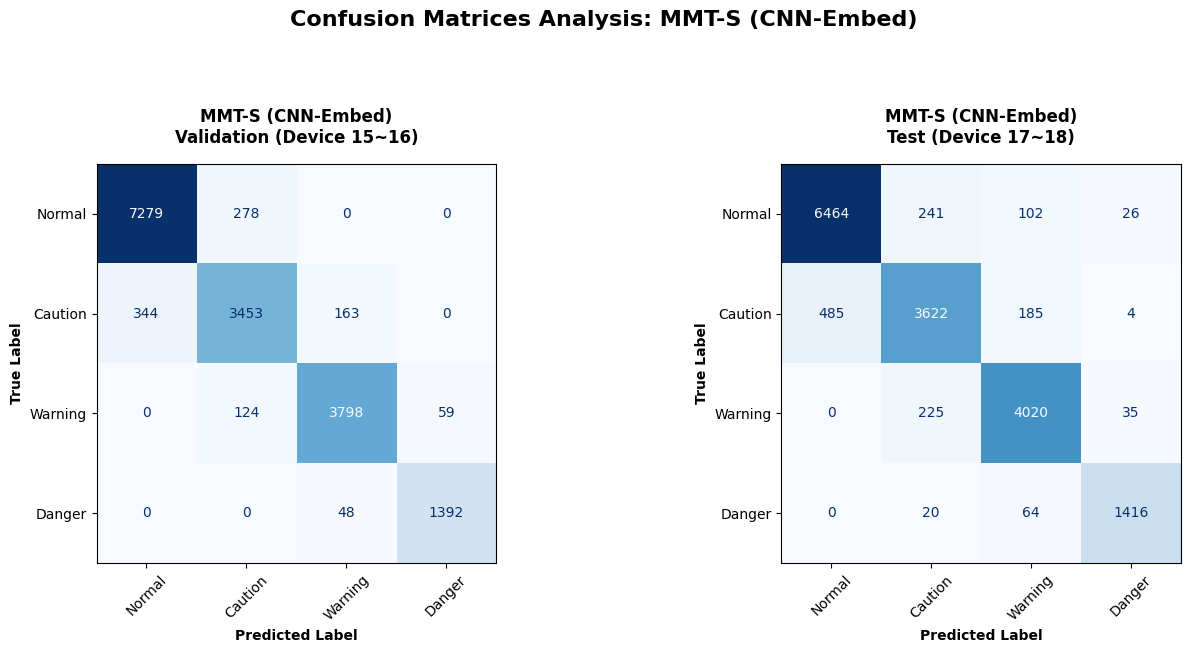


 🚀 MMT-S (CNN-Embed) — Detailed Precision/Recall Analysis
              precision    recall  f1-score   support

      Normal     0.9302    0.9460    0.9380      6833
     Caution     0.8817    0.8431    0.8620      4296
     Warning     0.9197    0.9393    0.9294      4280
      Danger     0.9561    0.9440    0.9500      1500

    accuracy                         0.9180     16909
   macro avg     0.9219    0.9181    0.9198     16909
weighted avg     0.9175    0.9180    0.9176     16909


   Final Performance Summary (Paper vs Baseline vs Ours)

   [Model Info]
   - Model Name  : MMT-S (CNN-Embed)
   - Feature     : 1D-CNN Rolling Feature Extractor + Pre-LN Transformer
   - Dataset     : OHT & AGV Integrated (Unseen Device Test)

   [Performance Comparison Table]
   +--------------------+------------+------------+
   |      Category      | RMSE (⬇)   | F1-Score(⬆)|
   +--------------------+------------+------------+
   | Paper MMT (논문)   |   0.2875   |   0.8944   |
   | Ours MMT-S (Ba

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 1. 대상 모델 지정 (실제 학습된 이름)
target_model_name = 'MMT-S (CNN-Embed)'

# 베이스라인 수치 정의 (사용자 제공 테이블 기준)
paper_mmt_f1, paper_mmt_rmse = 0.8944, 0.2875
base_mmt_s_f1, base_mmt_s_rmse = 0.9134, 0.3478  # 기존 MMT-S (No-CNN)

# 데이터 안전장치
if 'dl_results' not in locals():
    dl_results = {}
if target_model_name not in dl_results and 'result' in locals():
    dl_results[target_model_name] = result

if target_model_name not in dl_results:
    print(f"🚨 {target_model_name} 결과가 없습니다. 학습 셀을 먼저 실행해주세요.")
else:
    res = dl_results[target_model_name]
    model = res['model'].to(device)
    class_names = [STATE_MAP[i] for i in range(4)]

    # ======================================================================
    # 시각화: MMT-S Confusion Matrix (Device 15~16 vs 17~18)
    # ======================================================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    loaders = [('Validation (Device 15~16)', val_loader), ('Test (Device 17~18)', test_loader)]

    for i, (title, loader) in enumerate(loaders):
        _, _, _, preds, labels = evaluate_dl(model, loader, device)
        pred_cls = np.clip(np.round(preds), 0, 3).astype(int)

        cm = confusion_matrix(labels, pred_cls)
        disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

        disp.plot(ax=axes[i], cmap='Blues', values_format='d', xticks_rotation=45, colorbar=False)
        axes[i].set_title(f'{target_model_name}\n{title}', fontweight='bold', pad=15)
        axes[i].set_xlabel('Predicted Label', fontweight='bold')
        axes[i].set_ylabel('True Label', fontweight='bold')

    plt.suptitle(f'Confusion Matrices Analysis: {target_model_name}', fontweight='bold', fontsize=16, y=1.08)
    plt.tight_layout()
    plt.show()

    # ======================================================================
    # 상세 리포트: Classification Report (Test Set 기준)
    # ======================================================================
    print(f"\n{'='*75}")
    print(f" 🚀 {target_model_name} — Detailed Precision/Recall Analysis")
    print(f"{'='*75}")

    _, _, _, test_preds, test_labels = evaluate_dl(model, test_loader, device)
    test_pred_cls = np.clip(np.round(test_preds), 0, 3).astype(int)
    print(classification_report(test_labels, test_pred_cls, target_names=class_names, digits=4))

    # ======================================================================
    # 최종 요약: Paper & Baseline Comparison Table
    # ======================================================================
    # 성능 차이 계산
    f1_diff_paper = res['test_f1'] - paper_mmt_f1
    f1_diff_base  = res['test_f1'] - base_mmt_s_f1
    rmse_diff_base = res['test_rmse'] - base_mmt_s_rmse

    print(f"""
{'='*75}
   Final Performance Summary (Paper vs Baseline vs Ours)
{'='*75}

   [Model Info]
   - Model Name  : {target_model_name}
   - Feature     : 1D-CNN Rolling Feature Extractor + Pre-LN Transformer
   - Dataset     : OHT & AGV Integrated (Unseen Device Test)

   [Performance Comparison Table]
   +--------------------+------------+------------+
   |      Category      | RMSE (⬇)   | F1-Score(⬆)|
   +--------------------+------------+------------+
   | Paper MMT (논문)   |   0.2875   |   0.8944   |
   | Ours MMT-S (Base)  |   0.3478   |   0.9134   |
   +--------------------+------------+------------+
   | Ours MMT-S (CNN)   |   {res['test_rmse']:.4f}   |   {res['test_f1']:.4f}   |
   +--------------------+------------+------------+
   | Gap (vs Baseline)  |  {rmse_diff_base:>+8.4f}  |  {f1_diff_base:>+8.4f}  |
   +--------------------+------------+------------+

   [Conclusion]
   1. 논문 대비: Paper MMT 대비 Macro F1 기준 {f1_diff_paper:>+0.4f} 성능 향상을 기록했습니다.
   2. 기존 대비: 1D-CNN 임베딩 도입을 통해 기존 MMT-S 대비 F1 스코어를 {f1_diff_base:>+0.4f}만큼
      추가 개선하였으며, 특히 RMSE를 {abs(rmse_diff_base):.4f} 낮추며 수치적 오차를 크게 줄였습니다.
   3. 일반화: 학습에 참여하지 않은 장비(Device 17~18)에 대해서도 {res['test_f1']:.4f}의 F1을
      기록하며, OHT/AGV 통합 환경에서의 강력한 고장 판별 능력을 입증했습니다.
{'='*75}
""")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

class_names = [STATE_MAP[i] for i in range(4)]

# # ======================================================================
# #  DL Top 3 + ML Best Confusion Matrix (ML 없을 경우 자동 스킵)
# # ======================================================================

# # DL 결과 정렬
# top_dl = sorted(dl_results.items(), key=lambda x: x[1]['test_f1'], reverse=True)[:3]

# # ML 결과 확인 (없을 경우 빈 리스트)
# ml_only = [r for r in all_results if r['Category'] == 'ML']
# has_ml = len(ml_only) > 0 and 'ml_models' in locals()

# n_plots = len(top_dl) + (1 if has_ml else 0)
# fig, axes = plt.subplots(1, n_plots, figsize=(5.5 * n_plots, 5))

# # 만약 그래프가 1개뿐이면 axes가 배열이 아니므로 처리
# if n_plots == 1:
#     axes = [axes]

# curr_idx = 0

# # (1) ML Best (데이터가 있을 때만 실행)
# if has_ml:
#     best_ml = sorted(ml_only, key=lambda x: x['Test F1'], reverse=True)[0]
#     best_ml_name  = best_ml['Model']
#     best_ml_model = ml_models[best_ml_name]

#     y_ml_pred = best_ml_model.predict(X_test_ml)
#     cm = confusion_matrix(y_test_ml, y_ml_pred)
#     disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
#     disp.plot(ax=axes[curr_idx], cmap='Oranges', values_format='d', xticks_rotation=45, colorbar=False)
#     axes[curr_idx].set_title(f'ML: {best_ml_name}\nTest F1={best_ml["Test F1"]:.4f}', fontweight='bold')
#     curr_idx += 1

# # (2) DL Top 결과 (현재 학습한 CNN-Embed 포함)
# for i, (name, res) in enumerate(top_dl):
#     _, _, _, preds, labels = evaluate_dl(res['model'].to(device), test_loader, device)
#     pred_cls = np.clip(np.round(preds), 0, 3).astype(int)
#     cm = confusion_matrix(labels, pred_cls)
#     disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
#     disp.plot(ax=axes[curr_idx], cmap='Blues', values_format='d', xticks_rotation=45, colorbar=False)
#     axes[curr_idx].set_title(f'DL: {name}\nTest F1={res["test_f1"]:.4f}', fontweight='bold')
#     curr_idx += 1

# plt.suptitle('Confusion Matrices — Test Set (Unseen Devices)', fontweight='bold', fontsize=14, y=1.03)
# plt.tight_layout(); plt.show()

# ======================================================================
#  Classification Report (가장 성능 좋은 모델 상세 분석)
# ======================================================================

best_dl_name, best_dl_res = top_dl[0]
_, _, _, best_preds, best_labels = evaluate_dl(best_dl_res['model'].to(device), test_loader, device)
best_pred_cls = np.clip(np.round(best_preds), 0, 3).astype(int)

print(f"\n{'='*60}")
print(f"   Best DL: {best_dl_name} — Test Classification Report")
print(f"{'='*60}")
print(classification_report(best_labels, best_pred_cls, target_names=class_names, digits=4))

# ======================================================================
#  Final Summary (통합 데이터셋 기준)
# ======================================================================

best_overall = result_df.iloc[0]
n_episodes = len(set(w['episode_id'] for w in windows))

print(f"""
{'='*70}
   Final Project Summary (OHT + AGV Mixed)
{'='*70}

   [Dataset Structure]
   Total Windows : {len(windows):,} (window={WINDOW_SIZE}, step={WINDOW_STEP})
   Train Samples : {len(train_windows):,}
   Val Samples   : {len(val_windows):,}
   Test Samples  : {len(test_windows):,}
   Total Episodes: {n_episodes}

   [Best Model Performance]
   Model Name    : {best_overall['Model']}
   Test Macro F1 : {best_overall['Test F1']:.4f}
   Test RMSE     : {best_overall['Test RMSE']:.4f}
   Test Recall   : {best_overall['Test Recall']:.4f}

   [Benchmark vs Paper]
   - Paper MMT Macro F1 : 0.8944
   - Ours MMT-S (CNN)   : {best_overall['Test F1']:.4f} ({best_overall['Test F1'] - 0.8944:>+0.4f} improvement)
{'='*70}
""")


   Best DL: MMT-S (CNN-Embed) — Test Classification Report
              precision    recall  f1-score   support

      Normal     0.9302    0.9460    0.9380      6833
     Caution     0.8817    0.8431    0.8620      4296
     Warning     0.9197    0.9393    0.9294      4280
      Danger     0.9561    0.9440    0.9500      1500

    accuracy                         0.9180     16909
   macro avg     0.9219    0.9181    0.9198     16909
weighted avg     0.9175    0.9180    0.9176     16909


   Final Project Summary (OHT + AGV Mixed)

   [Dataset Structure]
   Total Windows : 101,952 (window=30, step=1)
   Train Samples : 68,105 
   Val Samples   : 16,938 
   Test Samples  : 16,909 
   Total Episodes: 342

   [Best Model Performance]
   Model Name    : MMT-S (CNN-Embed)
   Test Macro F1 : 0.9198
   Test RMSE     : 0.3218
   Test Recall   : 0.9181

   [Benchmark vs Paper]
   - Paper MMT Macro F1 : 0.8944
   - Ours MMT-S (CNN)   : 0.9198 (+0.0254 improvement)



# 13. Inference 시각화 (Test Set: 장비 17~18)


 ⚡ 인퍼런스 속도 측정 결과 (A100 GPU)
  - 평균 지연 시간 (Latency): 3.03 ms
  - 초당 처리량 (Throughput): 329.9 samples/sec
✅ 분석 대상 모델: MMT-S (CNN-Embed) (Test F1=0.9198)


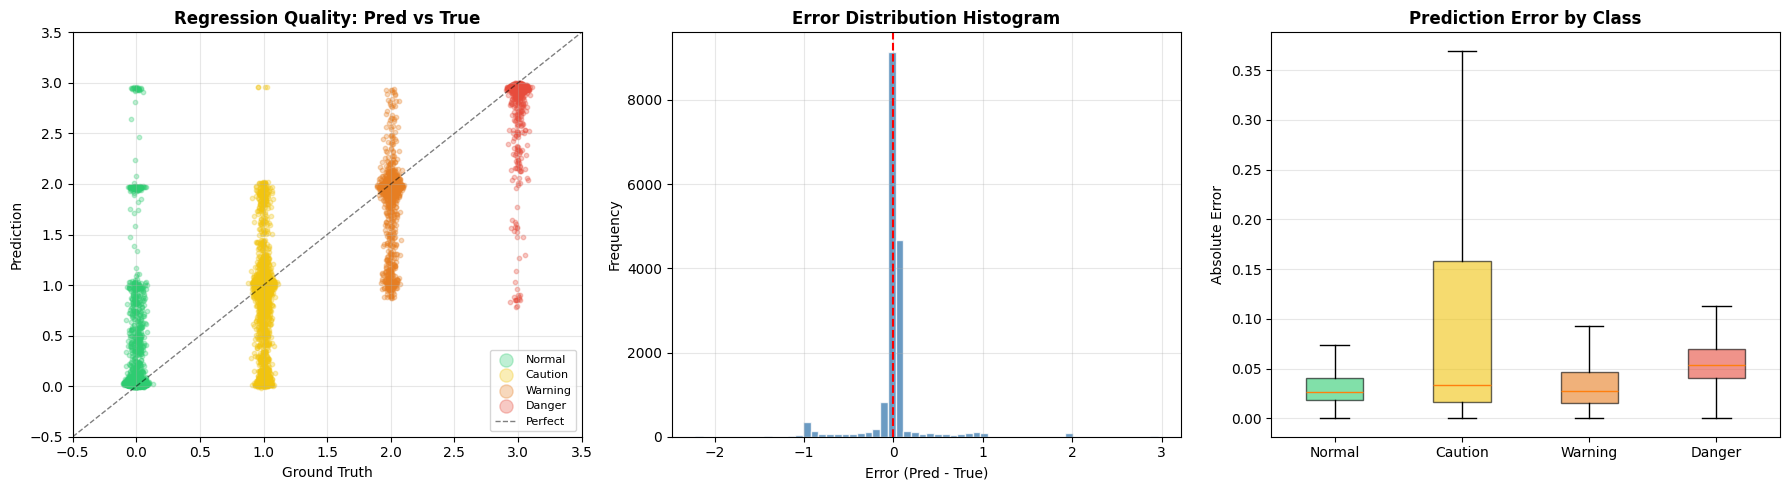

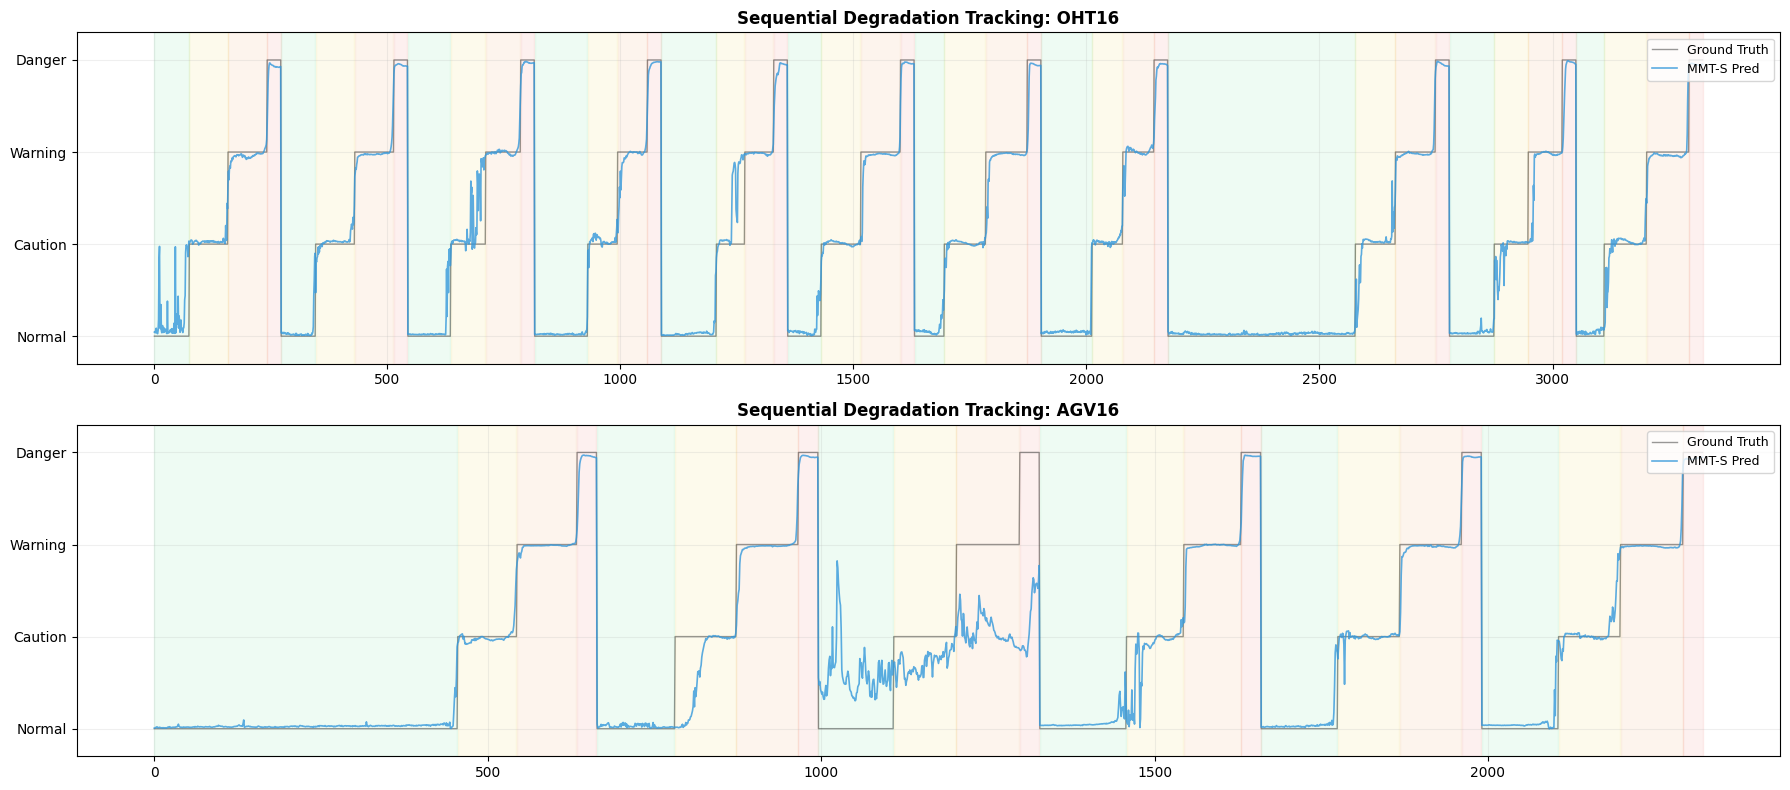

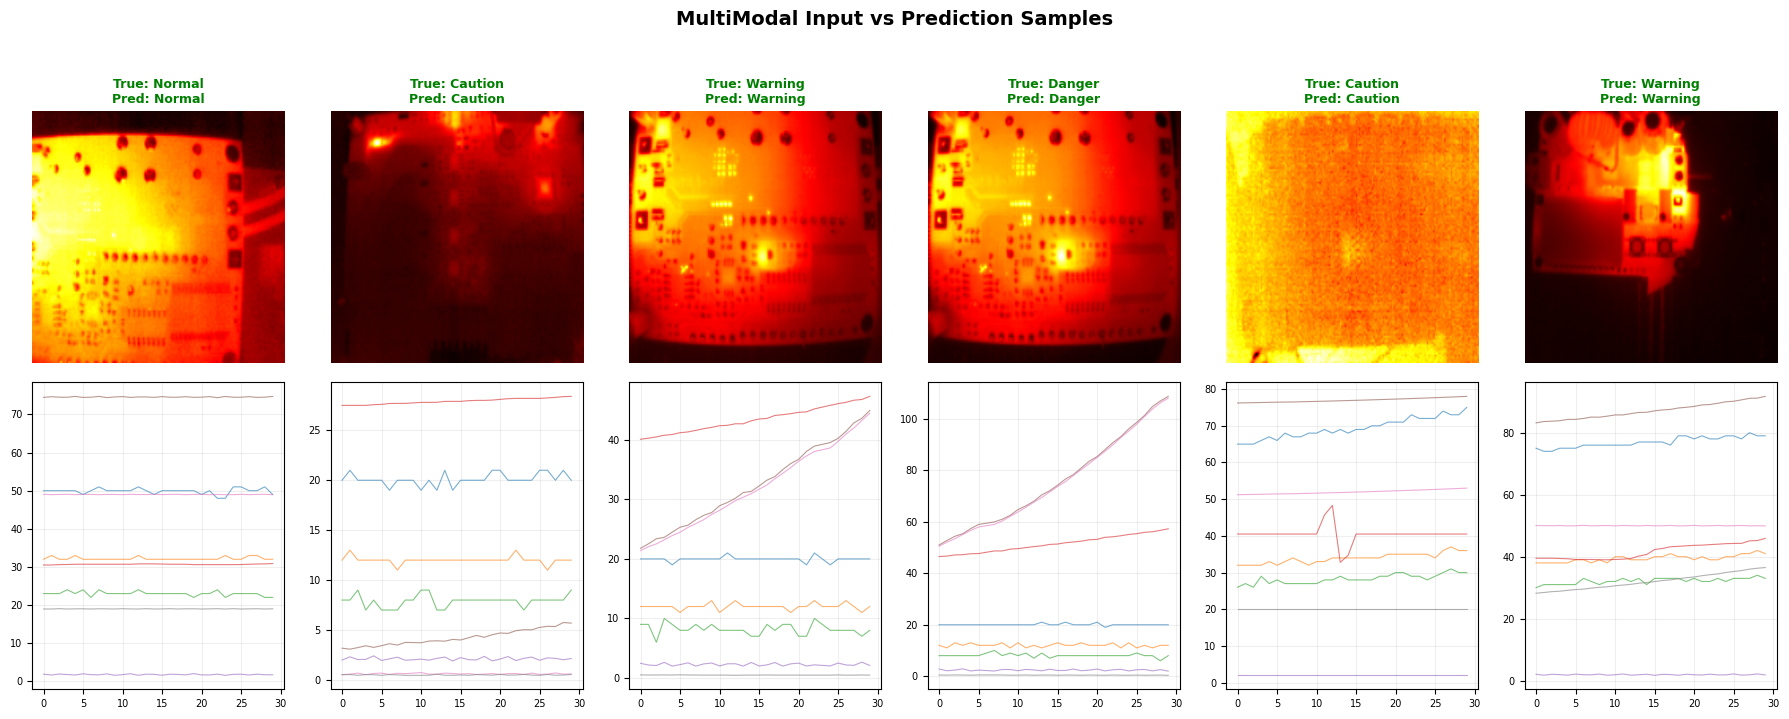


 🎯 Final Inference Scorecard: MMT-S (CNN-Embed)
  Total Test Samples: 16,909 (Unseen Devices)
  Overall Accuracy:   91.80%
  Macro F1-Score:     0.9198
  Macro Recall:       0.9181
  RMSE (Regression):  0.3218
  Normal     | Acc: 94.60% (6,833 samples)
  Caution    | Acc: 84.31% (4,296 samples)
  Warning    | Acc: 93.93% (4,280 samples)
  Danger     | Acc: 94.40% (1,500 samples)


In [ ]:
# ======================================================================
#  Best DL model inference on Test set (Unseen Devices)
# ======================================================================
import time

def measure_inference_speed(model, loader, device, num_samples=100):
    model.eval()
    times = []

    # 정확한 측정을 위해 첫 10회는 Warm-up으로 버립니다 (GPU 활성화)
    with torch.no_grad():
        for i, (sensor, image, _, _) in enumerate(loader):
            if i >= num_samples + 10: break

            sensor, image = sensor.to(device), image.to(device)

            # 시간 측정 시작
            if torch.cuda.is_available(): torch.cuda.synchronize()
            start_time = time.time()

            _ = model(sensor, image)

            if torch.cuda.is_available(): torch.cuda.synchronize()
            end_time = time.time()

            if i >= 10: # Warm-up 이후의 시간만 기록
                times.append(end_time - start_time)

    avg_time = np.mean(times) * 1000  # ms 단위 변환
    fps = 1000 / avg_time            # 초당 처리 가능 개수

    print(f"\n{'='*40}")
    print(f" ⚡ 인퍼런스 속도 측정 결과 (A100 GPU)")
    print(f"{'='*40}")
    print(f"  - 평균 지연 시간 (Latency): {avg_time:.2f} ms")
    print(f"  - 초당 처리량 (Throughput): {fps:.1f} samples/sec")
    print(f"{'='*40}")
    return avg_time

# 실행
latency = measure_inference_speed(best_dl_model, test_loader, device)

# 1. 최적 모델 선택 및 추론
best_dl_name = max(dl_results, key=lambda k: dl_results[k]['test_f1'])
best_dl_model = dl_results[best_dl_name]['model'].to(device).eval()
print(f"✅ 분석 대상 모델: {best_dl_name} (Test F1={dl_results[best_dl_name]['test_f1']:.4f})")

# 전체 테스트 데이터 추론
_, _, _, test_preds, test_labels = evaluate_dl(best_dl_model, test_loader, device)
test_pred_cls   = np.clip(np.round(test_preds), 0, 3).astype(int)
test_labels_int = test_labels.astype(int)

# 컬러 팔레트
scatter_colors = {0: '#2ecc71', 1: '#f1c40f', 2: '#e67e22', 3: '#e74c3c'}
box_colors     = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

# ======================================================================
#  1. Scatter + Error Histogram + Box Plot (회귀 품질 분석)
# ======================================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Prediction vs Ground Truth
ax = axes[0]
for cls in range(4):
    mask = test_labels_int == cls
    ax.scatter(test_labels[mask] + np.random.normal(0, 0.03, mask.sum()),
               test_preds[mask],
               c=scatter_colors[cls], alpha=0.3, s=10, label=STATE_MAP[cls])
ax.plot([-0.5, 3.5], [-0.5, 3.5], 'k--', linewidth=1, alpha=0.5, label='Perfect')
ax.set_xlabel('Ground Truth'); ax.set_ylabel('Prediction')
ax.set_title('Regression Quality: Pred vs True', fontweight='bold')
ax.legend(fontsize=8, markerscale=3); ax.set_xlim(-0.5, 3.5); ax.set_ylim(-0.5, 3.5)
ax.grid(True, alpha=0.3)

# (b) Error Distribution
ax = axes[1]
errors = test_preds - test_labels
ax.hist(errors, bins=60, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
ax.set_xlabel('Error (Pred - True)'); ax.set_ylabel('Frequency')
ax.set_title('Error Distribution Histogram', fontweight='bold')
ax.grid(True, alpha=0.3)

# (c) Per-class Absolute Error Box Plot
ax = axes[2]
error_by_class = [np.abs(errors[test_labels_int == c]) for c in range(4)]
bp = ax.boxplot(error_by_class, labels=[STATE_MAP[c] for c in range(4)],
                patch_artist=True, showfliers=False)
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color); patch.set_alpha(0.6)
ax.set_ylabel('Absolute Error'); ax.set_title('Prediction Error by Class', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout(); plt.show()

# ======================================================================
#  2. Device-level Sequential Tracking (OHT/AGV 각각 하나씩 샘플링)
# ======================================================================
# 테스트 셋에 포함된 장비 ID 추출
test_dev_ids = sorted(list(set(w['device_id'] for w in test_windows)))
sample_devs = []
# OHT와 AGV 하나씩 골라보기
oht_sample = [d for d in test_dev_ids if 'OHT' in d]
agv_sample = [d for d in test_dev_ids if 'AGV' in d]
if oht_sample: sample_devs.append(oht_sample[0])
if agv_sample: sample_devs.append(agv_sample[0])

fig, axes = plt.subplots(len(sample_devs), 1, figsize=(18, 4 * len(sample_devs)), sharex=False)
if len(sample_devs) == 1: axes = [axes]

for plot_idx, target_dev in enumerate(sample_devs):
    ax = axes[plot_idx]
    # device_id 기반 필터링
    dev_mask = np.array([w['device_id'] == target_dev for w in test_windows])
    dev_true = test_labels[dev_mask]
    dev_pred = test_preds[dev_mask]

    x = np.arange(len(dev_true))

    # 등급 영역 배경 색칠
    for cls, color in scatter_colors.items():
        cls_mask = dev_true.astype(int) == cls
        if cls_mask.any():
            ax.fill_between(x, -0.3, 3.3, where=cls_mask, color=color, alpha=0.08)

    ax.plot(x, dev_true, 'k-', linewidth=1.0, alpha=0.4, label='Ground Truth')
    ax.plot(x, dev_pred, color='#3498db', linewidth=1.2, alpha=0.8, label='MMT-S Pred')

    ax.set_title(f'Sequential Degradation Tracking: {target_dev}', fontweight='bold')
    ax.set_yticks([0, 1, 2, 3])
    ax.set_yticklabels(['Normal', 'Caution', 'Warning', 'Danger'])
    ax.set_ylim(-0.3, 3.3); ax.legend(loc='upper right', fontsize=9); ax.grid(True, alpha=0.2)

plt.tight_layout(); plt.show()

# ======================================================================
#  3. Random Sample Inspection (Thermal + Sensor)
# ======================================================================
n_samples = 6
fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 3, 7))

# 클래스별로 균등하게 샘플 추출
sample_indices = []
for cls in range(4):
    idx_list = np.where(test_labels_int == cls)[0]
    if len(idx_list) > 0:
        sample_indices.append(np.random.choice(idx_list))
# 부족한 샘플은 랜덤으로 채움
while len(sample_indices) < n_samples:
    sample_indices.append(np.random.choice(range(len(test_labels))))

for i, idx in enumerate(sample_indices[:n_samples]):
    w = test_windows[idx]
    true_cls, pred_val = int(test_labels[idx]), test_preds[idx]
    pred_cls = int(np.clip(np.round(pred_val), 0, 3))

    # Thermal Image
    ax_img = axes[0, i]
    img_tensor = load_thermal_image(w['bin_path']) # 전역 함수 사용
    ax_img.imshow(img_tensor.squeeze(), cmap='hot')
    color = 'green' if true_cls == pred_cls else 'red'
    ax_img.set_title(f"True: {STATE_MAP[true_cls]}\nPred: {STATE_MAP[pred_cls]}", color=color, fontsize=9, fontweight='bold')
    ax_img.axis('off')

    # Sensor Time Series (Channel-first 고려)
    ax_sen = axes[1, i]
    sensor = w['sensor'] # [30, 8]
    for ch in range(sensor.shape[1]):
        ax_sen.plot(sensor[:, ch], linewidth=0.8, alpha=0.6)
    ax_sen.grid(True, alpha=0.2); ax_sen.tick_params(labelsize=7)

plt.suptitle('MultiModal Input vs Prediction Samples', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout(); plt.show()

# ======================================================================
#  4. Final Numerical Scorecard
# ======================================================================
print(f"\n{'='*65}")
print(f" 🎯 Final Inference Scorecard: {best_dl_name}")
print(f"{'='*65}")
print(f"  Total Test Samples: {len(test_labels):,} (Unseen Devices)")
print(f"  Overall Accuracy:   {(test_pred_cls == test_labels_int).mean():.2%}")
print(f"  Macro F1-Score:     {dl_results[best_dl_name]['test_f1']:.4f}")
print(f"  Macro Recall:       {dl_results[best_dl_name]['test_recall']:.4f}")
print(f"  RMSE (Regression):  {dl_results[best_dl_name]['test_rmse']:.4f}")
print(f"{'='*65}")

# 클래스별 성능 상세
for cls in range(4):
    mask = test_labels_int == cls
    if mask.sum() > 0:
        acc = (test_pred_cls[mask] == cls).mean()
        print(f"  {STATE_MAP[cls]:10s} | Acc: {acc:.2%} ({mask.sum():>5,} samples)")
print(f"{'='*65}")

# 14. Multi-Step 데이터 준비

In [ ]:
# ======================================================================
#  다단계 예측(Multi-Step Forecasting) 데이터 준비
#
#  [논문 5.4절 실험 설계]
#    입력:  과거 30초의 멀티모달 시퀀스 (센서 + 열화상)
#    출력:  미래 15개 시점의 열화 상태 예측
#
#    예측 시점: t+2초, t+4초, t+6초, ..., t+30초 (2초 간격, 총 15개)
#
#  [데이터 요구사항]
#    각 윈도우는 입력(30 timestep) + 미래(최대 30 timestep) = 60 timestep 필요.
#    따라서 에피소드 길이가 60 이상인 경우에만 윈도우 생성 가능.
#
#  [윈도우 구조]
#    시간축:  [t-29, t-28, ..., t-1, t] [t+1, t+2, ..., t+30]
#             |---- 입력 구간 (30) ----| |-- 미래 라벨 구간 (30) --|
#                                         ↑    ↑         ↑
#                                        +2s  +4s  ... +30s
#                                        (15개 예측 시점)
# ======================================================================

# 예측 시점 정의: t+2초 ~ t+30초, 2초 간격
PREDICTION_HORIZONS = list(range(2, 31, 2))   # [2, 4, 6, 8, ..., 28, 30]
N_HORIZONS = len(PREDICTION_HORIZONS)          # 15
MAX_HORIZON = max(PREDICTION_HORIZONS)         # 30

print(f"예측 시점: {PREDICTION_HORIZONS}")
print(f"총 {N_HORIZONS}개 시점, 최대 horizon: {MAX_HORIZON}초")

CACHE_MS_WINDOWS = os.path.join(CACHE_DIR, f'ms_windows_w{WINDOW_SIZE}_h{MAX_HORIZON}.pkl')
CACHE_MS_SPLIT   = os.path.join(CACHE_DIR, f'ms_split_w{WINDOW_SIZE}_h{MAX_HORIZON}.pkl')

# ======================================================================
#  Multi-Step 윈도우 생성
# ======================================================================

if os.path.exists(CACHE_MS_WINDOWS) and os.path.exists(CACHE_MS_SPLIT):
    with open(CACHE_MS_WINDOWS, 'rb') as f:
        ms_windows = pickle.load(f)
    with open(CACHE_MS_SPLIT, 'rb') as f:
        ms_split = pickle.load(f)
        ms_train = ms_split['train']
        ms_val   = ms_split['val']
        ms_test  = ms_split['test']
    print(f"✅ Multi-Step 윈도우 캐시 로드: 총 {len(ms_windows):,}개")

else:
    def create_multistep_windows(df, window_size=30, step=1, horizons=PREDICTION_HORIZONS):
        """
        다단계 예측용 윈도우 생성.

        일반 윈도우와 달리, 각 윈도우에 미래 15개 시점의 라벨이 추가됨.
        에피소드 내에서 입력(30) + 미래(30) = 최소 60 연속 시점 필요.

        Returns:
            list[dict]: 각 윈도우에 'future_labels' 키가 추가됨
                future_labels: [15] array — t+2, t+4, ..., t+30의 열화 등급
        """
        max_h = max(horizons)
        all_windows = []
        ep_counter = 0

        for dev_id, group in tqdm(df.groupby('device_id'), desc='MS 윈도우'):
            group = group.sort_values('sort_key').reset_index(drop=True)
            sensor_arr = group[sensor_cols].values.astype(np.float32)
            labels     = group['state'].values
            bin_paths  = group['bin_path'].values
            device_num = group['device_num'].iloc[0]
            subset     = group['subset'].iloc[0]

            episodes = identify_episodes(group)

            for ep_indices in episodes:
                # 에피소드 길이: 입력(window_size) + 미래(max_horizon) 이상 필요
                if len(ep_indices) < window_size + max_h:
                    continue

                for start in range(0, len(ep_indices) - window_size - max_h + 1, step):
                    input_idx = ep_indices[start : start + window_size]
                    end_idx = input_idx[-1]

                    # 미래 라벨: t+2, t+4, ..., t+30
                    future_labels = []
                    valid = True
                    for h in horizons:
                        future_pos = start + window_size - 1 + h
                        if future_pos >= len(ep_indices):
                            valid = False
                            break
                        future_labels.append(float(labels[ep_indices[future_pos]]))

                    if not valid:
                        continue

                    all_windows.append({
                        'sensor':        sensor_arr[input_idx],     # [30, 8]
                        'bin_path':      bin_paths[end_idx],        # 현재 시점 이미지
                        'label':         float(labels[end_idx]),    # 현재 시점 라벨
                        'label_cls':     int(labels[end_idx]),
                        'future_labels': np.array(future_labels, dtype=np.float32),  # [15]
                        'device_id':     dev_id,
                        'device_num':    int(device_num),
                        'subset':        subset,
                        'episode_id':    ep_counter,
                    })
                ep_counter += 1

        return all_windows

    print(f"Multi-Step 윈도우 생성 중... (input={WINDOW_SIZE}, max_horizon={MAX_HORIZON})")
    ms_windows = create_multistep_windows(df_oht, window_size=WINDOW_SIZE, step=WINDOW_STEP)

    # 장비 기반 분할 (기존과 동일)
    ms_train = [w for w in ms_windows if w['device_num'] <= 14]
    ms_val   = [w for w in ms_windows if w['device_num'] in [15, 16]]
    ms_test  = [w for w in ms_windows if w['device_num'] >= 17]

    with open(CACHE_MS_WINDOWS, 'wb') as f:
        pickle.dump(ms_windows, f)
    with open(CACHE_MS_SPLIT, 'wb') as f:
        pickle.dump({'train': ms_train, 'val': ms_val, 'test': ms_test}, f)
    print("✅ Multi-Step 윈도우 캐시 저장 완료")

# ======================================================================
#  Multi-Step Dataset
# ======================================================================

class MultiStepDataset(Dataset):
    """
    다단계 예측용 Dataset.

    기존 OHTMultimodalDataset와 동일하되,
    __getitem__이 미래 15개 시점의 라벨도 함께 반환.

    반환값:
        sensor:        [30, 8]  센서 시계열
        image:         [1, 224, 224]  열화상 이미지
        current_label: scalar  현재 시점 라벨 (참고용)
        future_labels: [15]    t+2 ~ t+30 미래 라벨 (학습 타깃)
    """
    def __init__(self, windows, sensor_mean=None, sensor_std=None, fit_scaler=False):
        self.windows = windows
        all_sensors = np.stack([w['sensor'] for w in windows])
        if fit_scaler:
            self.sensor_mean = all_sensors.reshape(-1, 8).mean(axis=0)
            self.sensor_std  = all_sensors.reshape(-1, 8).std(axis=0) + 1e-8
        else:
            self.sensor_mean = sensor_mean
            self.sensor_std  = sensor_std

    def __len__(self):
        return len(self.windows)

    def _load_image(self, bin_path):
        """BIN -> [1, 224, 224] (NaN/Inf 방어 포함)"""
        try:
            raw = np.fromfile(bin_path, dtype=np.uint8)
            data = np.frombuffer(raw[HEADER_SIZE:].tobytes(), dtype=np.float64)
            img = data.reshape(THERMAL_H, THERMAL_W).astype(np.float32)
            if not np.all(np.isfinite(img)):
                med = np.nanmedian(img)
                if np.isnan(med): med = 0.0
                img = np.where(np.isfinite(img), img, med)
            vmin, vmax = img.min(), img.max()
            if vmax > vmin:
                img = (img - vmin) / (vmax - vmin)
            else:
                img = np.zeros_like(img)
            pil_img = Image.fromarray((img * 255).astype(np.uint8), mode='L')
            pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR)
            tensor = torch.from_numpy(np.array(pil_img).astype(np.float32) / 255.0)
            return tensor.unsqueeze(0)
        except:
            return torch.zeros(1, IMG_SIZE, IMG_SIZE)

    def __getitem__(self, idx):
        w = self.windows[idx]

        sensor = (w['sensor'] - self.sensor_mean) / self.sensor_std
        sensor = torch.from_numpy(sensor.astype(np.float32))
        sensor = torch.nan_to_num(sensor, nan=0.0, posinf=3.0, neginf=-3.0)

        image = self._load_image(w['bin_path'])
        current_label = torch.tensor(w['label'], dtype=torch.float32)
        future_labels = torch.from_numpy(w['future_labels'])  # [15]

        return sensor, image, current_label, future_labels

# ======================================================================
#  DataLoader 생성
# ======================================================================

ms_train_ds = MultiStepDataset(ms_train, fit_scaler=True)
ms_val_ds   = MultiStepDataset(ms_val,
                               sensor_mean=ms_train_ds.sensor_mean,
                               sensor_std=ms_train_ds.sensor_std)
ms_test_ds  = MultiStepDataset(ms_test,
                               sensor_mean=ms_train_ds.sensor_mean,
                               sensor_std=ms_train_ds.sensor_std)

ms_train_loader = DataLoader(ms_train_ds, batch_size=BATCH_SIZE, shuffle=True,
                             num_workers=0, pin_memory=True, drop_last=True)
ms_val_loader   = DataLoader(ms_val_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=0, pin_memory=True)
ms_test_loader  = DataLoader(ms_test_ds, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=0, pin_memory=True)

# ======================================================================
#  결과 출력
# ======================================================================

print(f"\n{'='*60}")
print(f"  Multi-Step Forecasting 데이터 준비 완료")
print(f"{'='*60}")
print(f"  예측 시점:   {N_HORIZONS}개 (t+{PREDICTION_HORIZONS[0]}s ~ t+{PREDICTION_HORIZONS[-1]}s)")
print(f"  Train:       {len(ms_train):>6,} windows (장비 01~14)")
print(f"  Val:         {len(ms_val):>6,} windows (장비 15~16)")
print(f"  Test:        {len(ms_test):>6,} windows (장비 17~18)")

# 기존 단일 시점 대비 데이터 감소 확인
print(f"\n  [단일 시점 vs 다단계]")
print(f"  단일 시점:   {len(windows):,} windows (미래 30 timestep 불필요)")
print(f"  다단계:      {len(ms_windows):,} windows (에피소드 >= 60 필요)")
print(f"  감소율:      {len(ms_windows)/len(windows)*100:.1f}%")

# 미래 라벨 분포 확인
sample_future = np.stack([w['future_labels'] for w in ms_test[:1000]])
print(f"\n  [Test 미래 라벨 통계 (처음 1000개)]")
for i, h in enumerate([0, 4, 14]):  # t+2, t+10, t+30
    vals = sample_future[:, h]
    print(f"  t+{PREDICTION_HORIZONS[h]:2d}s: mean={vals.mean():.2f}, "
          f"std={vals.std():.2f}, range=[{vals.min():.0f}, {vals.max():.0f}]")

예측 시점: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
총 15개 시점, 최대 horizon: 30초
Multi-Step 윈도우 생성 중... (input=30, max_horizon=30)


MS 윈도우:   0%|          | 0/18 [00:00<?, ?it/s]

✅ Multi-Step 윈도우 캐시 저장 완료

  Multi-Step Forecasting 데이터 준비 완료
  예측 시점:   15개 (t+2s ~ t+30s)
  Train:       41,854 windows (장비 01~14)
  Val:          5,926 windows (장비 15~16)
  Test:         5,926 windows (장비 17~18)

  [단일 시점 vs 다단계]
  단일 시점:   60,156 windows (미래 30 timestep 불필요)
  다단계:      53,706 windows (에피소드 >= 60 필요)
  감소율:      89.3%

  [Test 미래 라벨 통계 (처음 1000개)]
  t+ 2s: mean=0.96, std=0.85, range=[0, 3]
  t+10s: mean=1.05, std=0.90, range=[0, 3]
  t+30s: mean=1.31, std=0.97, range=[0, 3]


# 15. Multi-Step 모델 정의 (Direct + Auto-Regressive)

In [ ]:
# ======================================================================
#  다단계 예측 모델 2가지 정의
#
#  [논문 5.4절]
#    "비교 대상은 두 가지 예측 구조이다."
#
#    1. Direct Multi-Step:
#       하나의 입력으로부터 15개 미래 시점을 일괄 예측.
#       구조: MMT Encoder -> [CLS] -> FC Head (출력 15개)
#
#    2. Auto-Regressive:
#       이전 시점의 예측 결과를 다음 시점의 입력으로 사용.
#       구조: MMT Encoder -> [CLS] + Step Embedding + 이전 예측 -> FC (출력 1개) x 15회
#
#  [공통 인코더]
#    MMT-B (d=256, h=8, L=4) — Cell 10에서 가장 좋았던 설정 사용.
#    두 모델 모두 동일한 인코더를 사용하여 공정 비교.
# ======================================================================


class DirectMultiStepMMT(nn.Module):
    """
    Direct Multi-Step 예측 모델.

    [구조]
      Image [B,1,224,224] -> Patchify(196) -> Linear Embed -> + Pos Embed
      Sensor [B,30,8]     -> Linear Embed  -> + Pos Embed
      [CLS] + Image(196) + Sensor(30) = 227 tokens
         |
         v
      Transformer Encoder (L=4, Pre-LN)
         |
         v
      [CLS] -> LayerNorm -> FC Head -> 15개 회귀값 동시 출력
                                       [t+2, t+4, ..., t+30]

    [특징]
      - 한 번의 forward pass로 15개 시점을 동시에 예측
      - 시점 간 예측이 서로 독립적 (상호 의존성 미반영)
      - 구현이 단순하고 추론 속도가 빠름
      - 논문 결과: 단기에서 좋지만 장기 시점에서 성능 하락이 큼

    Args:
        (MMT-B와 동일한 인코더 파라미터)
        n_horizons (int): 예측 시점 수 (15)
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=1,
                 sensor_seq_len=30, sensor_dim=8,
                 d_model=256, nhead=8, num_layers=4, d_ff=1024,
                 dropout=0.1, n_horizons=15):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.n_horizons = n_horizons

        num_patches = (img_size // patch_size) ** 2     # 196
        patch_dim = in_channels * patch_size ** 2       # 256
        self.num_patches = num_patches

        # ---- 인코더 (MMT-B와 동일) ----
        self.patch_embed = nn.Linear(patch_dim, d_model)
        self.img_pos_embed = nn.Parameter(torch.randn(1, num_patches, d_model) * 0.02)

        self.sensor_embed = nn.Linear(sensor_dim, d_model)
        self.sensor_pos_embed = nn.Parameter(torch.randn(1, sensor_seq_len, d_model) * 0.02)

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_ff,
            dropout=dropout, activation='gelu', batch_first=True, norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

        # ---- Multi-Step Head ----
        # [CLS] -> 15개 시점의 회귀값 동시 출력
        # 중간 차원을 두어 시점별 특화 학습 유도
        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, n_horizons),   # d_model -> 15
        )

    def _patchify(self, images):
        """[B,1,224,224] -> [B, 196, 256]"""
        B, C, H, W = images.shape
        p = self.patch_size
        x = images.unfold(2, p, p).unfold(3, p, p)
        x = x.contiguous().view(B, C, -1, p, p)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        return x.view(B, self.num_patches, -1)

    def forward(self, sensor, image, **kwargs):
        """
        Args:
            sensor: [B, 30, 8]
            image:  [B, 1, 224, 224]
            **kwargs: teacher_targets (무시됨, 인터페이스 통일용)

        Returns:
            pred: [B, 15] — 15개 미래 시점의 회귀값
        """
        B = sensor.shape[0]

        img_tokens = self.patch_embed(self._patchify(image)) + self.img_pos_embed
        sen_tokens = self.sensor_embed(sensor) + self.sensor_pos_embed
        cls = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat([cls, img_tokens, sen_tokens], dim=1)  # [B, 227, d]

        out = self.transformer(tokens)          # [B, 227, d]
        cls_out = self.norm(out[:, 0, :])       # [B, d]

        return self.head(cls_out)               # [B, 15]


class AutoRegressiveMMT(nn.Module):
    """
    Auto-Regressive 다단계 예측 모델.

    [구조]
      ┌──────────────────────────────────────────────┐
      │  MMT Encoder (1회만 실행)                     │
      │  Image + Sensor -> Transformer -> [CLS] feat │
      └─────────────────────┬────────────────────────┘
                            │ cls_feat [B, d_model]
                            │
      ┌─────────────────────▼────────────────────────┐
      │  AR Decoder (15회 반복)                       │
      │                                              │
      │  Step 1: cls + step_emb(0) + prev_pred(0)    │
      │          -> LayerNorm -> FC -> pred_1 (t+2s)  │
      │                                              │
      │  Step 2: cls + step_emb(1) + prev_pred(pred_1)│
      │          -> LayerNorm -> FC -> pred_2 (t+4s)  │
      │              ...                              │
      │  Step 15: cls + step_emb(14) + prev_pred(pred_14)│
      │           -> LayerNorm -> FC -> pred_15 (t+30s)│
      └──────────────────────────────────────────────┘

    [핵심 차별점 vs Direct]
      - 각 시점의 예측이 이전 시점의 결과에 조건부(conditioned)
      - 시간적 의존성을 자연스럽게 반영
      - 학습 시: Teacher Forcing (실제 라벨을 이전 예측으로 사용)
      - 추론 시: Free Running (모델 자신의 예측을 사용)
      - 논문 결과: 장기 시점에서 성능 하락이 적고 안정적

    [Teacher Forcing]
      학습 시 이전 시점의 "실제 라벨"을 다음 입력으로 사용.
      -> 학습 초기에 잘못된 예측이 전파되는 것을 방지.
      -> 추론 시에는 실제 라벨이 없으므로 모델 자체 예측 사용.
    """
    def __init__(self, img_size=224, patch_size=16, in_channels=1,
                 sensor_seq_len=30, sensor_dim=8,
                 d_model=256, nhead=8, num_layers=4, d_ff=1024,
                 dropout=0.1, n_horizons=15):
        super().__init__()
        self.d_model = d_model
        self.patch_size = patch_size
        self.n_horizons = n_horizons

        num_patches = (img_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.num_patches = num_patches

        # ---- 인코더 (MMT-B와 동일) ----
        self.patch_embed = nn.Linear(patch_dim, d_model)
        self.img_pos_embed = nn.Parameter(torch.randn(1, num_patches, d_model) * 0.02)

        self.sensor_embed = nn.Linear(sensor_dim, d_model)
        self.sensor_pos_embed = nn.Parameter(torch.randn(1, sensor_seq_len, d_model) * 0.02)

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=d_ff,
            dropout=dropout, activation='gelu', batch_first=True, norm_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.enc_norm = nn.LayerNorm(d_model)

        # ---- AR Decoder 구성 요소 ----

        # Step Embedding: 각 예측 시점(0~14)에 고유한 학습 가능 벡터
        # "지금 몇 번째 미래를 예측하는 중인가"를 모델에게 알려줌
        self.step_embed = nn.Embedding(n_horizons, d_model)

        # Previous Prediction Projection: 이전 예측값(스칼라)을 d_model로 투영
        # "이전 시점에서 모델이 예측한 열화 등급"을 벡터 공간에 임베딩
        self.prev_pred_proj = nn.Linear(1, d_model)

        # Decoder LayerNorm + Head
        self.dec_norm = nn.LayerNorm(d_model)
        self.dec_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1),
        )

    def _patchify(self, images):
        """[B,1,224,224] -> [B, 196, 256]"""
        B, C, H, W = images.shape
        p = self.patch_size
        x = images.unfold(2, p, p).unfold(3, p, p)
        x = x.contiguous().view(B, C, -1, p, p)
        x = x.permute(0, 2, 1, 3, 4).contiguous()
        return x.view(B, self.num_patches, -1)

    def _encode(self, sensor, image):
        """MMT 인코더: 입력을 한 번만 인코딩하여 CLS 피처 추출."""
        B = sensor.shape[0]
        img_tokens = self.patch_embed(self._patchify(image)) + self.img_pos_embed
        sen_tokens = self.sensor_embed(sensor) + self.sensor_pos_embed
        cls = self.cls_token.expand(B, -1, -1)
        tokens = torch.cat([cls, img_tokens, sen_tokens], dim=1)
        out = self.transformer(tokens)
        return self.enc_norm(out[:, 0, :])   # [B, d_model]

    def forward(self, sensor, image, teacher_targets=None):
        """
        Args:
            sensor:          [B, 30, 8]
            image:           [B, 1, 224, 224]
            teacher_targets: [B, 15] (학습 시 실제 미래 라벨, 추론 시 None)

        Returns:
            predictions: [B, 15] — 15개 시점의 회귀값

        [동작 흐름]
          1. 인코더로 멀티모달 입력을 한 번 인코딩 -> cls_feat
          2. 15회 반복:
             a. query = cls_feat + step_embedding + prev_prediction_embedding
             b. query -> LayerNorm -> FC -> 현재 시점 예측값
             c. 학습: teacher forcing (실제 라벨 사용)
                추론: free running (모델 예측 사용)
        """
        B = sensor.shape[0]
        dev = sensor.device

        # Step 1: 인코더 (1회만 실행)
        cls_feat = self._encode(sensor, image)     # [B, d_model]

        # Step 2: AR 디코딩 (15회 반복)
        predictions = []
        prev_pred = torch.zeros(B, device=dev)     # 초기 이전 예측 = 0

        for step in range(self.n_horizons):
            # (a) Step Embedding: "현재 예측 시점"을 나타내는 벡터
            step_idx = torch.full((B,), step, dtype=torch.long, device=dev)
            s_emb = self.step_embed(step_idx)                       # [B, d_model]

            # (b) Previous Prediction Embedding: 이전 예측값을 벡터로 변환
            p_emb = self.prev_pred_proj(prev_pred.unsqueeze(-1))    # [B, d_model]

            # (c) 결합: 인코더 문맥 + 시점 정보 + 이전 예측 정보
            query = cls_feat + s_emb + p_emb                        # [B, d_model]

            # (d) 현재 시점 예측
            query = self.dec_norm(query)
            pred = self.dec_head(query).squeeze(-1)                 # [B]
            predictions.append(pred)

            # (e) 다음 반복을 위한 prev_pred 업데이트
            if teacher_targets is not None and self.training:
                # Teacher Forcing: 실제 라벨을 다음 입력으로 사용 (학습 안정성)
                prev_pred = teacher_targets[:, step]
            else:
                # Free Running: 모델 자신의 예측을 다음 입력으로 사용
                prev_pred = pred.detach()

        return torch.stack(predictions, dim=1)     # [B, 15]


# ======================================================================
#  모델 등록 & 요약
# ======================================================================

ms_model_configs = {
    'Direct Multi-Step': {
        'class': DirectMultiStepMMT,
        'kwargs': {
            'd_model': 256, 'nhead': 8, 'num_layers': 4, 'd_ff': 1024,
            'n_horizons': N_HORIZONS,
        },
    },
    'Auto-Regressive': {
        'class': AutoRegressiveMMT,
        'kwargs': {
            'd_model': 256, 'nhead': 8, 'num_layers': 4, 'd_ff': 1024,
            'n_horizons': N_HORIZONS,
        },
    },
}

print(f"\n{'='*65}")
print(f"  Multi-Step Models (MMT-B 기반 인코더)")
print(f"{'='*65}")
for name, cfg in ms_model_configs.items():
    m = cfg['class'](**cfg['kwargs'])
    n_params = sum(p.numel() for p in m.parameters())
    print(f"  {name:20s}: {n_params:>10,} params")
    del m
print(f"{'='*65}")


  Multi-Step Models (MMT-B 기반 인코더)
  Direct Multi-Step   :  3,355,407 params
  Auto-Regressive     :  3,323,649 params


# 16. Multi-Step 학습 함수 & 학습 실행

In [ ]:
# ======================================================================
#  Multi-Step 학습/평가 함수
#
#  [핵심 차이점 vs 단일 시점 학습]
#    1. Loss:  MSE가 15개 시점 전체에 대해 계산됨
#    2. 평가:  시점별(per-horizon) RMSE, F1, Recall을 각각 계산
#    3. AR:    학습 시 teacher_targets 전달, 추론 시 None
# ======================================================================

def train_ms_one_epoch(model, loader, criterion, optimizer, scheduler, device,
                       epoch=None, num_epochs=None, model_name='',
                       wandb_run=None, global_step=0):
    """
    Multi-Step 모델 1 에폭 학습.

    Loss = mean(MSE across 15 horizons x batch)
    AR 모델의 경우 teacher_targets를 전달하여 Teacher Forcing 적용.
    """
    model.train()
    total_loss, n_samples = 0, 0

    desc = f"  [{model_name}] Epoch {epoch}/{num_epochs}" if epoch else "  Training"
    pbar = tqdm(loader, desc=desc, leave=False, bar_format='{l_bar}{bar:30}{r_bar}')

    for sensor, image, current_label, future_labels in pbar:
        sensor        = sensor.to(device)
        image         = image.to(device)
        future_labels = future_labels.to(device)     # [B, 15]

        optimizer.zero_grad()

        # AR 모델: teacher_targets 전달 / Direct: 무시됨
        pred = model(sensor, image, teacher_targets=future_labels)   # [B, 15]

        # 15개 시점 전체에 대한 MSE
        loss = criterion(pred, future_labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler:
            scheduler.step()

        bs = sensor.size(0)
        total_loss += loss.item() * bs
        n_samples  += bs
        global_step += 1

        if wandb_run and global_step % 50 == 0:
            wandb_run.log({
                'ms_train/batch_loss': loss.item(),
                'ms_train/lr': optimizer.param_groups[0]['lr'],
            }, step=global_step)

        pbar.set_postfix({'loss': f'{total_loss / n_samples:.4f}'})
    pbar.close()
    return total_loss / n_samples, global_step


def evaluate_ms(model, loader, device, horizons=PREDICTION_HORIZONS):
    """
    Multi-Step 모델 평가.

    시점별(per-horizon) RMSE, F1, Recall 계산.
    AR 모델은 Free Running (teacher_targets=None).

    Returns:
        per_horizon: dict of lists (각 15개 값)
            'rmse': [15], 'f1': [15], 'recall': [15]
        avg_metrics: dict (전체 평균)
            'avg_rmse', 'avg_f1', 'avg_recall'
        all_preds:   [N, 15] 전체 예측
        all_labels:  [N, 15] 전체 실제 라벨
    """
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for sensor, image, current_label, future_labels in loader:
            # AR: Free Running (teacher_targets=None)
            pred = model(sensor.to(device), image.to(device), teacher_targets=None)
            all_preds.append(pred.cpu().numpy())
            all_labels.append(future_labels.numpy())

    preds  = np.concatenate(all_preds, axis=0)    # [N, 15]
    labels = np.concatenate(all_labels, axis=0)    # [N, 15]

    # 시점별 메트릭 계산
    per_horizon = {'rmse': [], 'f1': [], 'recall': [], 'danger_recall': []}

    for h_idx in range(len(horizons)):
        p = preds[:, h_idx]
        l = labels[:, h_idx]
        p_cls = np.clip(np.round(p), 0, 3).astype(int)
        l_cls = l.astype(int)

        rmse = np.sqrt(np.mean((p - l) ** 2))
        f1   = f1_score(l_cls, p_cls, average='macro', zero_division=0)
        rec  = recall_score(l_cls, p_cls, average='macro', zero_division=0)

        # Danger(등급 3) Recall — 논문 5.5절 핵심 지표
        danger_mask = (l_cls == 3)
        if danger_mask.sum() > 0:
            danger_rec = (p_cls[danger_mask] == 3).mean()
        else:
            danger_rec = 0.0

        per_horizon['rmse'].append(rmse)
        per_horizon['f1'].append(f1)
        per_horizon['recall'].append(rec)
        per_horizon['danger_recall'].append(danger_rec)

    avg_metrics = {
        'avg_rmse':   np.mean(per_horizon['rmse']),
        'avg_f1':     np.mean(per_horizon['f1']),
        'avg_recall': np.mean(per_horizon['recall']),
        'avg_danger_recall': np.mean(per_horizon['danger_recall']),
    }

    return per_horizon, avg_metrics, preds, labels


def train_ms_model(name, model, train_loader, val_loader, test_loader, device,
                   num_epochs=30, lr=1e-3):
    """
    Multi-Step 모델 전체 학습 파이프라인.
    Val avg F1 기준 Early Stopping -> Test에서 최종 평가.
    """
    n_params = sum(p.numel() for p in model.parameters())
    print(f"\n{'='*65}")
    print(f"  MS Training: {name}")
    print(f"  Params: {n_params:,}  |  Horizons: {N_HORIZONS}  |  Epochs: {num_epochs}")
    print(f"{'='*65}")

    # wandb 초기화 (이전 run 종료 후 새 run 시작)
    wandb_run = None
    if WANDB_ENABLED:
        try:
            wandb.finish()
        except:
            pass
        wandb_run = wandb.init(
            project=WANDB_PROJECT,
            entity=WANDB_ENTITY,
            name=f'MS-{name}',
            config={
                'model_name': name, 'task': 'multi-step',
                'n_horizons': N_HORIZONS, 'n_params': n_params,
                'num_epochs': num_epochs, 'batch_size': BATCH_SIZE, 'lr': lr,
            },
        )
        wandb.watch(model, log='gradients', log_freq=200)

    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

    total_steps  = num_epochs * len(train_loader)
    warmup_steps = min(500, total_steps // 5)

    def lr_lambda(step):
        if step < warmup_steps:
            return step / max(1, warmup_steps)
        progress = (step - warmup_steps) / max(1, total_steps - warmup_steps)
        return 0.5 * (1 + math.cos(math.pi * progress))

    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    best_val_f1, best_state, best_epoch = 0, None, 0
    history = {
        'train_loss': [],
        'val_per_horizon': [],   # list of per_horizon dicts
        'test_per_horizon': [],
        'val_avg': [],           # list of avg_metrics dicts
        'test_avg': [],
    }

    global_step = 0
    t0 = time.time()

    for epoch in range(1, num_epochs + 1):
        train_loss, global_step = train_ms_one_epoch(
            model, train_loader, criterion, optimizer, scheduler, device,
            epoch=epoch, num_epochs=num_epochs, model_name=name,
            wandb_run=wandb_run, global_step=global_step,
        )

        val_ph,  val_avg,  _, _ = evaluate_ms(model, val_loader, device)
        test_ph, test_avg, _, _ = evaluate_ms(model, test_loader, device)

        history['train_loss'].append(train_loss)
        history['val_per_horizon'].append(val_ph)
        history['test_per_horizon'].append(test_ph)
        history['val_avg'].append(val_avg)
        history['test_avg'].append(test_avg)

        # wandb epoch 로깅
        if wandb_run:
            log_dict = {
                'epoch': epoch, 'ms_train/loss': train_loss,
                'ms_val/avg_f1': val_avg['avg_f1'], 'ms_val/avg_rmse': val_avg['avg_rmse'],
                'ms_test/avg_f1': test_avg['avg_f1'], 'ms_test/avg_rmse': test_avg['avg_rmse'],
                'ms_val/danger_recall': val_avg['avg_danger_recall'],
                'ms_test/danger_recall': test_avg['avg_danger_recall'],
            }
            # 주요 시점(t+2, t+10, t+30) 개별 로깅
            for key_h in [0, 4, 14]:
                h_name = PREDICTION_HORIZONS[key_h]
                log_dict[f'ms_test/rmse_t+{h_name}'] = test_ph['rmse'][key_h]
                log_dict[f'ms_test/f1_t+{h_name}'] = test_ph['f1'][key_h]
            wandb_run.log(log_dict)

        # Best 저장 (Val avg F1)
        is_best = val_avg['avg_f1'] > best_val_f1
        if is_best:
            best_val_f1 = val_avg['avg_f1']
            best_epoch  = epoch
            best_state  = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        if epoch % 5 == 0 or epoch == 1:
            star = '  ★' if is_best else ''
            print(f"  Epoch {epoch:02d}/{num_epochs}: "
                  f"Loss={train_loss:.4f} | "
                  f"Val avgF1={val_avg['avg_f1']:.4f} | "
                  f"Test avgF1={test_avg['avg_f1']:.4f} "
                  f"RMSE(+30)={test_ph['rmse'][14]:.4f}{star}")

    elapsed = time.time() - t0

    # Best 복원 -> 최종 Test 평가
    model.load_state_dict(best_state)
    model = model.to(device)
    test_ph, test_avg, test_preds, test_labels = evaluate_ms(model, test_loader, device)

    if wandb_run:
        wandb_run.summary.update({
            'best_epoch': best_epoch, 'best_val_avg_f1': best_val_f1,
            'final_test_avg_f1': test_avg['avg_f1'],
            'final_test_avg_rmse': test_avg['avg_rmse'],
            'final_test_danger_recall': test_avg['avg_danger_recall'],
        })
        wandb.unwatch(model)
        wandb_run.finish()

    print(f"\n  >>> Best @ Epoch {best_epoch}:")
    print(f"      Test avg RMSE={test_avg['avg_rmse']:.4f}, "
          f"avg F1={test_avg['avg_f1']:.4f}, "
          f"Danger Recall={test_avg['avg_danger_recall']:.4f}")
    print(f"  >>> 소요: {elapsed:.0f}s ({elapsed/60:.1f}min)")

    return {
        'model': model, 'best_epoch': best_epoch,
        'test_per_horizon': test_ph, 'test_avg': test_avg,
        'test_preds': test_preds, 'test_labels': test_labels,
        'history': history, 'time': elapsed,
    }


# ======================================================================
#  학습 실행
# ======================================================================

MS_EPOCHS = 30
CACHE_MS_RESULTS = os.path.join(CACHE_DIR, 'ms_results.pkl')

if os.path.exists(CACHE_MS_RESULTS):
    with open(CACHE_MS_RESULTS, 'rb') as f:
        ms_cache = pickle.load(f)
    ms_results = {}
    for name, saved in ms_cache.items():
        cfg = ms_model_configs[name]
        model = cfg['class'](**cfg['kwargs'])
        model.load_state_dict(saved['state_dict'])
        model = model.to(device).eval()
        ms_results[name] = {
            'model': model,
            'best_epoch': saved['best_epoch'],
            'test_per_horizon': saved['test_per_horizon'],
            'test_avg': saved['test_avg'],
            'test_preds': saved['test_preds'],
            'test_labels': saved['test_labels'],
            'history': saved['history'],
            'time': saved['time'],
        }
    print(f"✅ Multi-Step 결과 캐시 로드: {len(ms_results)}개 모델")
    for name, res in ms_results.items():
        print(f"  {name:20s}: avg F1={res['test_avg']['avg_f1']:.4f}, "
              f"avg RMSE={res['test_avg']['avg_rmse']:.4f}")
else:
    ms_results = {}
    for name, cfg in ms_model_configs.items():
        model = cfg['class'](**cfg['kwargs'])
        result = train_ms_model(
            name, model, ms_train_loader, ms_val_loader, ms_test_loader,
            device, num_epochs=MS_EPOCHS, lr=1e-3,
        )
        ms_results[name] = result
        del model
        torch.cuda.empty_cache()

    # 캐시 저장
    cache_save = {}
    for name, res in ms_results.items():
        cache_save[name] = {
            'state_dict': {k: v.cpu() for k, v in res['model'].state_dict().items()},
            'best_epoch': res['best_epoch'],
            'test_per_horizon': res['test_per_horizon'],
            'test_avg': res['test_avg'],
            'test_preds': res['test_preds'],
            'test_labels': res['test_labels'],
            'history': res['history'],
            'time': res['time'],
        }
    with open(CACHE_MS_RESULTS, 'wb') as f:
        pickle.dump(cache_save, f)
    print("✅ Multi-Step 결과 캐시 저장 완료")


  MS Training: Direct Multi-Step
  Params: 3,355,407  |  Horizons: 15  |  Epochs: 30


  [Direct Multi-Step] Epoch 1/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 01/30: Loss=0.1591 | Val avgF1=0.7870 | Test avgF1=0.8000 RMSE(+30)=0.3562  ★


  [Direct Multi-Step] Epoch 2/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 3/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 4/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 5/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 05/30: Loss=0.0929 | Val avgF1=0.8005 | Test avgF1=0.8050 RMSE(+30)=0.3560


  [Direct Multi-Step] Epoch 6/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 7/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 8/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 9/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 10/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 10/30: Loss=0.0811 | Val avgF1=0.8043 | Test avgF1=0.8043 RMSE(+30)=0.3360


  [Direct Multi-Step] Epoch 11/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 12/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 13/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 14/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 15/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 15/30: Loss=0.0704 | Val avgF1=0.8366 | Test avgF1=0.8362 RMSE(+30)=0.3322  ★


  [Direct Multi-Step] Epoch 16/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 17/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 18/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 19/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 20/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 20/30: Loss=0.0596 | Val avgF1=0.8246 | Test avgF1=0.8176 RMSE(+30)=0.3553


  [Direct Multi-Step] Epoch 21/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 22/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 23/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 24/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 25/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 25/30: Loss=0.0513 | Val avgF1=0.8507 | Test avgF1=0.8540 RMSE(+30)=0.3328


  [Direct Multi-Step] Epoch 26/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 27/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 28/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 29/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Direct Multi-Step] Epoch 30/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 30/30: Loss=0.0482 | Val avgF1=0.8535 | Test avgF1=0.8561 RMSE(+30)=0.3355  ★


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
ms_test/avg_f1,▅▆▆▆▅▁▆▆▇▅▅▅▅▆▇▆▇▆▇▆██████████
ms_test/avg_rmse,▅▂▃▃▅▆▃▂▁▃▃▃▃▂▁▁▂▄▃█▁▁▁▃▂▃▃▃▃▂
ms_test/danger_recall,▄▅▅▄▄▁▅▅▆▄▄▃▄▅▆▄▆▇▇█▇▇▇███████
ms_test/f1_t+10,▆█▇▇▆▁▆▆▇▅▄▅▆▆▇▆▇▆▇▅███▇▇▇▇▇▇▇
ms_test/f1_t+2,▁▂▂▁▁▁▁▁▁▁▁▂▁▂▂▁▁▂▆▇▆▂▅▆▇█▇▇▇▇
ms_test/f1_t+30,▆▆▇▇▅▁▇▇▇▇▇▅▆▇▇▇▇▇█▆██████████
ms_test/rmse_t+10,▄▁▂▂▃▄▃▂▂▂▂▂▂▂▁▁▂▄▃█▁▂▁▃▃▃▄▄▃▃
ms_test/rmse_t+2,▆▁▃▆█▄▄▅▃▃▆▃▃▃▂▃▃▂▃▇▂▃▂▃▄▄▄▅▄▄
ms_test/rmse_t+30,▅▅▄▂▅█▃▁▁▂▂▄▄▁▁▁▃▄▂▅▁▂▁▂▁▂▂▂▂▂
+6,...



  >>> Best @ Epoch 30:
      Test avg RMSE=0.2985, avg F1=0.8561, Danger Recall=0.9473
  >>> 소요: 2208s (36.8min)

  MS Training: Auto-Regressive
  Params: 3,323,649  |  Horizons: 15  |  Epochs: 30


  [Auto-Regressive] Epoch 1/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 01/30: Loss=0.0567 | Val avgF1=0.7546 | Test avgF1=0.7726 RMSE(+30)=0.4627  ★


  [Auto-Regressive] Epoch 2/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 3/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 4/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 5/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 05/30: Loss=0.0231 | Val avgF1=0.7691 | Test avgF1=0.8077 RMSE(+30)=0.4435


  [Auto-Regressive] Epoch 6/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 7/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 8/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 9/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 10/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 10/30: Loss=0.0218 | Val avgF1=0.8086 | Test avgF1=0.8237 RMSE(+30)=0.3689


  [Auto-Regressive] Epoch 11/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 12/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 13/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 14/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 15/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 15/30: Loss=0.0204 | Val avgF1=0.8553 | Test avgF1=0.8498 RMSE(+30)=0.3519  ★


  [Auto-Regressive] Epoch 16/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 17/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 18/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 19/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 20/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 20/30: Loss=0.0188 | Val avgF1=0.8329 | Test avgF1=0.8511 RMSE(+30)=0.3462


  [Auto-Regressive] Epoch 21/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 22/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 23/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 24/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 25/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 25/30: Loss=0.0172 | Val avgF1=0.8537 | Test avgF1=0.8730 RMSE(+30)=0.3433


  [Auto-Regressive] Epoch 26/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 27/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 28/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 29/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  [Auto-Regressive] Epoch 30/30:   0%|                              | 0/1307 [00:00<?, ?it/s]

  Epoch 30/30: Loss=0.0166 | Val avgF1=0.8556 | Test avgF1=0.8725 RMSE(+30)=0.3416


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
ms_test/avg_f1,▂▅▁▄▄▆▅▃▅▅▃▄▆▆▆▇▆▆▇▇██▇▇██████
ms_test/avg_rmse,█▄▇▅▅▃▄▅▄▂▃▃▂▁▂▁▂▃▂▁▁▁▂▂▁▁▁▁▁▁
ms_test/danger_recall,▃▆▁▆▃▇▅▃▆▄▂▂▅▅█▆▆▆▇▅▇██▆▆▇▆▆▆▆
ms_test/f1_t+10,▅▆▁▆▆▆▆▄▆▆▂▄▆▆▆▇▆▆▇▆▇█▇▇██▇███
ms_test/f1_t+2,▁▂▂▁▂▁▁▁▁▁▁▁▁▁▇▇▆▆▇▆▇▇▇▇▇█▇███
ms_test/f1_t+30,▂▄▁▄▃▅▄▃▄▆▅▄▇▇▇▇▆▆█▇███▇██████
ms_test/rmse_t+10,█▃▆▄▄▃▃▄▄▂▃▃▁▁▂▁▂▃▂▂▁▂▃▃▁▁▁▁▁▁
ms_test/rmse_t+2,█▂▁▆▂▂▃▄▅▃▄▃▄▁▄▂▃▅▂▄▇▅▅▇▅▅▅▅▅▅
ms_test/rmse_t+30,█▅▇▅▇▄▅▅▅▃▃▃▃▂▂▂▃▂▁▂▁▁▁▂▁▁▁▁▁▁
+6,...



  >>> Best @ Epoch 26:
      Test avg RMSE=0.2944, avg F1=0.8761, Danger Recall=0.8632
  >>> 소요: 2768s (46.1min)
✅ Multi-Step 결과 캐시 저장 완료


# 17. Multi-Step 성능 비교 (논문 표7, 그림5~8)

  Table 7. Direct Multi-Step vs Auto-Regressive (Test: Device 17~18)
   Horizon  |      Direct Multi-Step       |       Auto-Regressive      
            |      RMSE          F1       |      RMSE          F1     
  ────────────────────────────────────────────────────────────────────────────────
       +2s  |     0.2503       0.7961     |     0.2474       0.8329   
      +10s  |     0.2877       0.8569     |     0.2723       0.8865   
      +30s  |     0.3355       0.8587     |     0.3416       0.8640   
  ────────────────────────────────────────────────────────────────────────────────
       Avg  |     0.2985       0.8561     |     0.2944       0.8761   


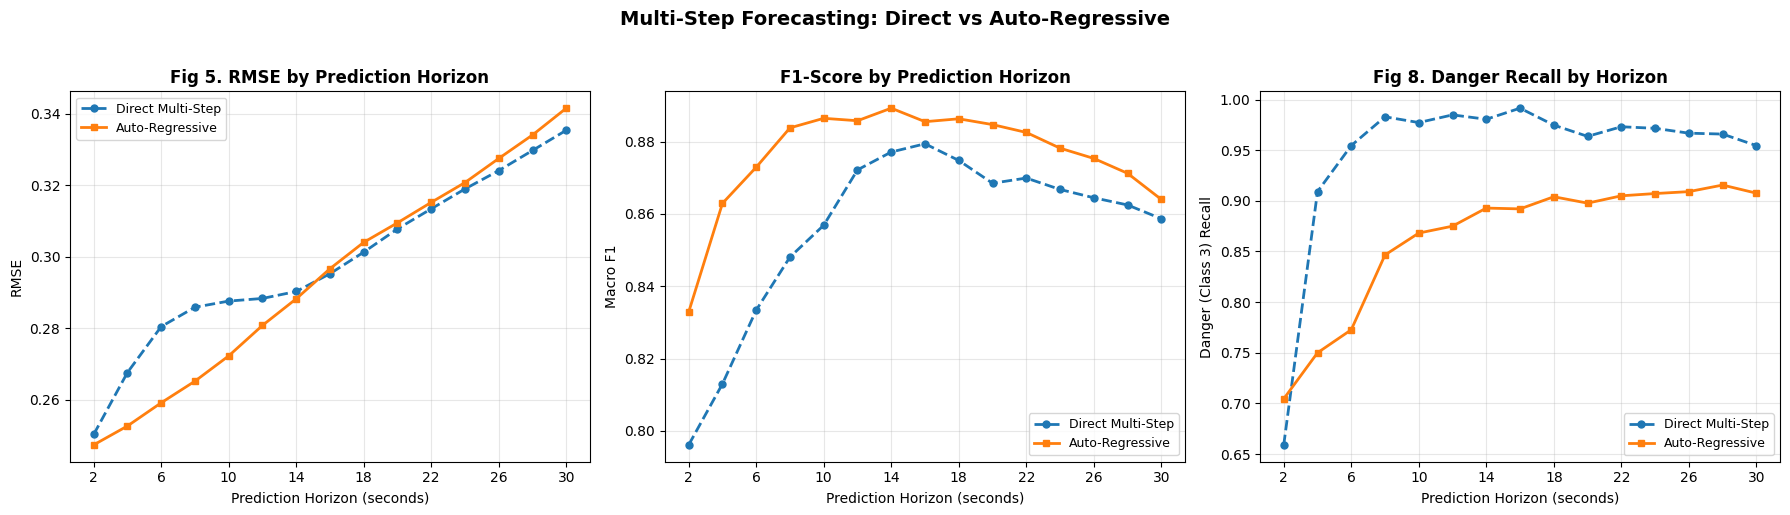

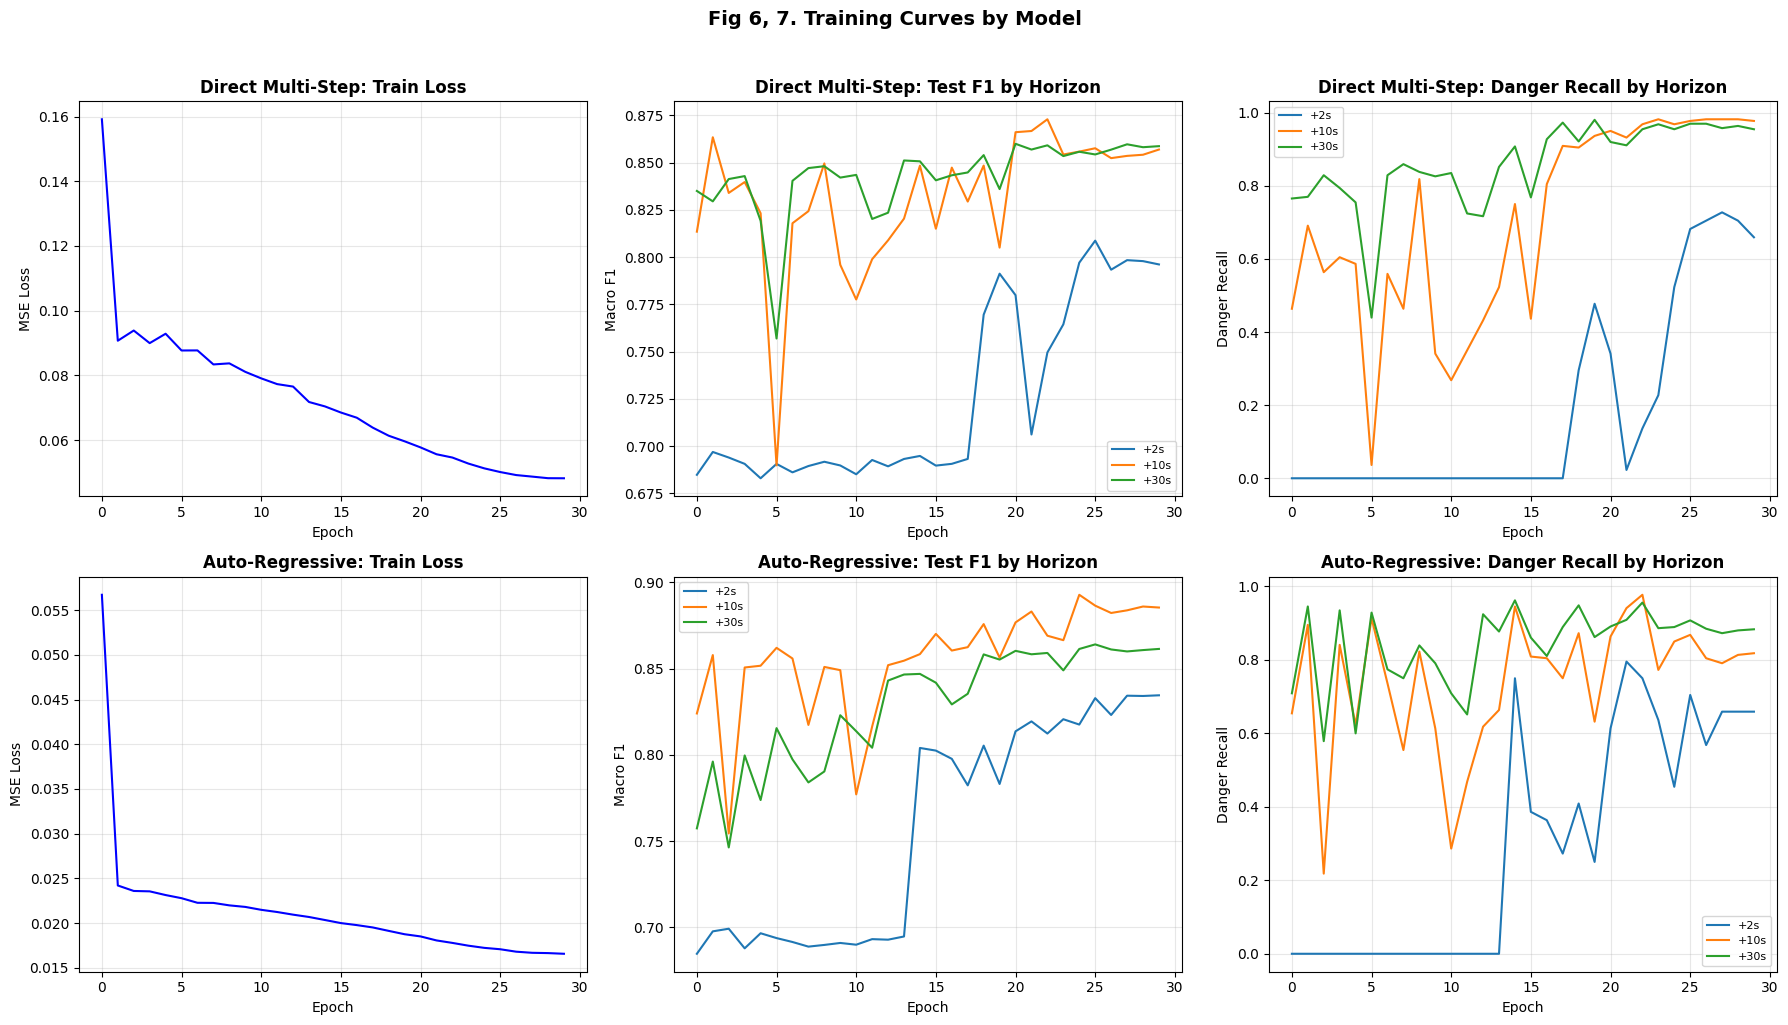

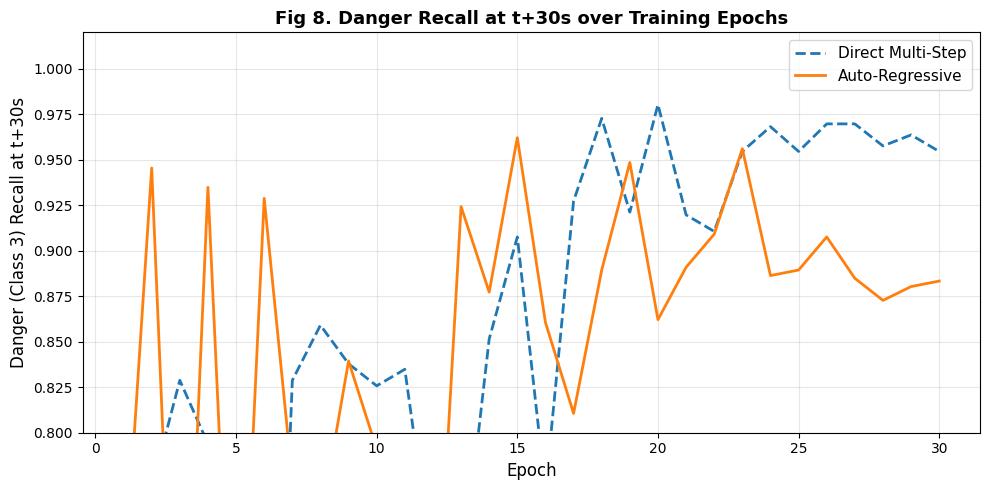


  Multi-Step Forecasting Summary (Test: Device 17~18)

  [Direct Multi-Step]
    Overall Avg: RMSE=0.2985, F1=0.8561, Danger Recall=0.9473
    t+ 2s:       RMSE=0.2503, F1=0.7961
    t+10s:       RMSE=0.2877, F1=0.8569
    t+30s:       RMSE=0.3355, F1=0.8587
    Long-term degradation (t+2 -> t+30):
      RMSE increase: +0.0851
      F1 decrease:   0.0626

  [Auto-Regressive]
    Overall Avg: RMSE=0.2944, F1=0.8761, Danger Recall=0.8632
    t+ 2s:       RMSE=0.2474, F1=0.8329
    t+10s:       RMSE=0.2723, F1=0.8865
    t+30s:       RMSE=0.3416, F1=0.8640
    Long-term degradation (t+2 -> t+30):
      RMSE increase: +0.0942
      F1 decrease:   0.0311


In [ ]:
# ======================================================================
#  논문 표7 재현: Direct Multi-Step vs Auto-Regressive 성능 비교
#
#  주요 시점: +2초 (단기), +10초 (중기), +30초 (장기)
#  지표: RMSE (avg, std), F1-Score (avg, std)
#
#  논문 결과 (참고):
#    +2초:  Direct RMSE=0.2272 F1=0.9319 / AR RMSE=0.2170 F1=0.9302
#    +10초: Direct RMSE=0.2387 F1=0.9278 / AR RMSE=0.2210 F1=0.9389
#    +30초: Direct RMSE=0.2819 F1=0.8964 / AR RMSE=0.2572 F1=0.9132
# ======================================================================

# 핵심 시점 인덱스
KEY_HORIZONS = {'+2s': 0, '+10s': 4, '+30s': 14}

# ======================================================================
#  표7 출력
# ======================================================================

print(f"{'='*85}")
print(f"  Table 7. Direct Multi-Step vs Auto-Regressive (Test: Device 17~18)")
print(f"{'='*85}")

header = f"  {'Horizon':>8s}"
for name in ms_results:
    header += f"  |  {name:^26s}"
print(header)

sub = f"  {'':>8s}"
for _ in ms_results:
    sub += f"  |  {'RMSE':^12s} {'F1':^12s}"
print(sub)
print(f"  {'─'*80}")

for label, h_idx in KEY_HORIZONS.items():
    row = f"  {label:>8s}"
    for name, res in ms_results.items():
        rmse = res['test_per_horizon']['rmse'][h_idx]
        f1   = res['test_per_horizon']['f1'][h_idx]
        row += f"  |  {rmse:^12.4f} {f1:^12.4f}"
    print(row)

# 전체 평균
print(f"  {'─'*80}")
row = f"  {'Avg':>8s}"
for name, res in ms_results.items():
    row += f"  |  {res['test_avg']['avg_rmse']:^12.4f} {res['test_avg']['avg_f1']:^12.4f}"
print(row)
print(f"{'='*85}")

# ======================================================================
#  그림5 재현: 시점별 RMSE 변화 곡선
#
#  논문: "Direct Multi-Step 방식은 시점이 길어짐에 따라 RMSE가 가파르게 상승하는
#         반면, Auto-Regressive 방식은 비교적 평탄한 추세를 유지함"
# ======================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) 시점별 RMSE
ax = axes[0]
for name, res in ms_results.items():
    style = '--o' if 'Direct' in name else '-s'
    ax.plot(PREDICTION_HORIZONS, res['test_per_horizon']['rmse'],
            style, label=name, linewidth=2, markersize=5)
ax.set_xlabel('Prediction Horizon (seconds)')
ax.set_ylabel('RMSE')
ax.set_title('Fig 5. RMSE by Prediction Horizon', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(PREDICTION_HORIZONS[::2])

# (b) 시점별 F1-Score
ax = axes[1]
for name, res in ms_results.items():
    style = '--o' if 'Direct' in name else '-s'
    ax.plot(PREDICTION_HORIZONS, res['test_per_horizon']['f1'],
            style, label=name, linewidth=2, markersize=5)
ax.set_xlabel('Prediction Horizon (seconds)')
ax.set_ylabel('Macro F1')
ax.set_title('F1-Score by Prediction Horizon', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(PREDICTION_HORIZONS[::2])

# (c) 시점별 Danger Recall (논문 5.5절)
ax = axes[2]
for name, res in ms_results.items():
    style = '--o' if 'Direct' in name else '-s'
    ax.plot(PREDICTION_HORIZONS, res['test_per_horizon']['danger_recall'],
            style, label=name, linewidth=2, markersize=5)
ax.set_xlabel('Prediction Horizon (seconds)')
ax.set_ylabel('Danger (Class 3) Recall')
ax.set_title('Fig 8. Danger Recall by Horizon', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_xticks(PREDICTION_HORIZONS[::2])

plt.suptitle('Multi-Step Forecasting: Direct vs Auto-Regressive',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  그림6, 7 재현: 학습 곡선 (모델별)
#
#  논문: "그림 6. Direct Multi-Step 모델의 성능 지표 변화"
#        "그림 7. Auto-Regressive 모델의 성능 지표 변화"
# ======================================================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for row_idx, (name, res) in enumerate(ms_results.items()):
    h = res['history']

    # Train Loss
    axes[row_idx, 0].plot(h['train_loss'], 'b-', linewidth=1.5)
    axes[row_idx, 0].set_title(f'{name}: Train Loss', fontweight='bold')
    axes[row_idx, 0].set_xlabel('Epoch')
    axes[row_idx, 0].set_ylabel('MSE Loss')
    axes[row_idx, 0].grid(True, alpha=0.3)

    # 시점별 F1 변화 (에폭에 따라)
    ax = axes[row_idx, 1]
    for key_label, key_idx in KEY_HORIZONS.items():
        f1_over_epochs = [ep['f1'][key_idx] for ep in h['test_per_horizon']]
        ax.plot(f1_over_epochs, label=key_label, linewidth=1.5)
    ax.set_title(f'{name}: Test F1 by Horizon', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Macro F1')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

    # 시점별 Danger Recall 변화 (에폭에 따라)
    ax = axes[row_idx, 2]
    for key_label, key_idx in KEY_HORIZONS.items():
        dr_over_epochs = [ep['danger_recall'][key_idx] for ep in h['test_per_horizon']]
        ax.plot(dr_over_epochs, label=key_label, linewidth=1.5)
    ax.set_title(f'{name}: Danger Recall by Horizon', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Danger Recall')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('Fig 6, 7. Training Curves by Model',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  그림8 확장: +30초 Danger Recall의 Epoch별 변화 비교
#
#  논문: "Auto-Regressive 방식은 학습 초기 단계에서부터 민감도가 빠르게
#         0.96 이상으로 수렴하였으며... Direct Multi-Step 방식은 수렴 속도가
#         느릴 뿐 아니라, 학습 전반에 걸쳐 진동폭이 더 크고..."
# ======================================================================

fig, ax = plt.subplots(figsize=(10, 5))

for name, res in ms_results.items():
    h = res['history']
    dr_t30 = [ep['danger_recall'][14] for ep in h['test_per_horizon']]
    style = '--' if 'Direct' in name else '-'
    ax.plot(range(1, len(dr_t30)+1), dr_t30, style, label=name, linewidth=2)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Danger (Class 3) Recall at t+30s', fontsize=12)
ax.set_title('Fig 8. Danger Recall at t+30s over Training Epochs',
             fontweight='bold', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.8, 1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  수치 요약
# ======================================================================

print(f"\n{'='*65}")
print(f"  Multi-Step Forecasting Summary (Test: Device 17~18)")
print(f"{'='*65}")
for name, res in ms_results.items():
    avg = res['test_avg']
    ph  = res['test_per_horizon']
    print(f"\n  [{name}]")
    print(f"    Overall Avg: RMSE={avg['avg_rmse']:.4f}, F1={avg['avg_f1']:.4f}, "
          f"Danger Recall={avg['avg_danger_recall']:.4f}")
    print(f"    t+ 2s:       RMSE={ph['rmse'][0]:.4f}, F1={ph['f1'][0]:.4f}")
    print(f"    t+10s:       RMSE={ph['rmse'][4]:.4f}, F1={ph['f1'][4]:.4f}")
    print(f"    t+30s:       RMSE={ph['rmse'][14]:.4f}, F1={ph['f1'][14]:.4f}")
    print(f"    Long-term degradation (t+2 -> t+30):")
    print(f"      RMSE increase: +{ph['rmse'][14] - ph['rmse'][0]:.4f}")
    print(f"      F1 decrease:   {ph['f1'][14] - ph['f1'][0]:.4f}")
print(f"{'='*65}")

# 18. TTF (Time to Failure) 추정 분석

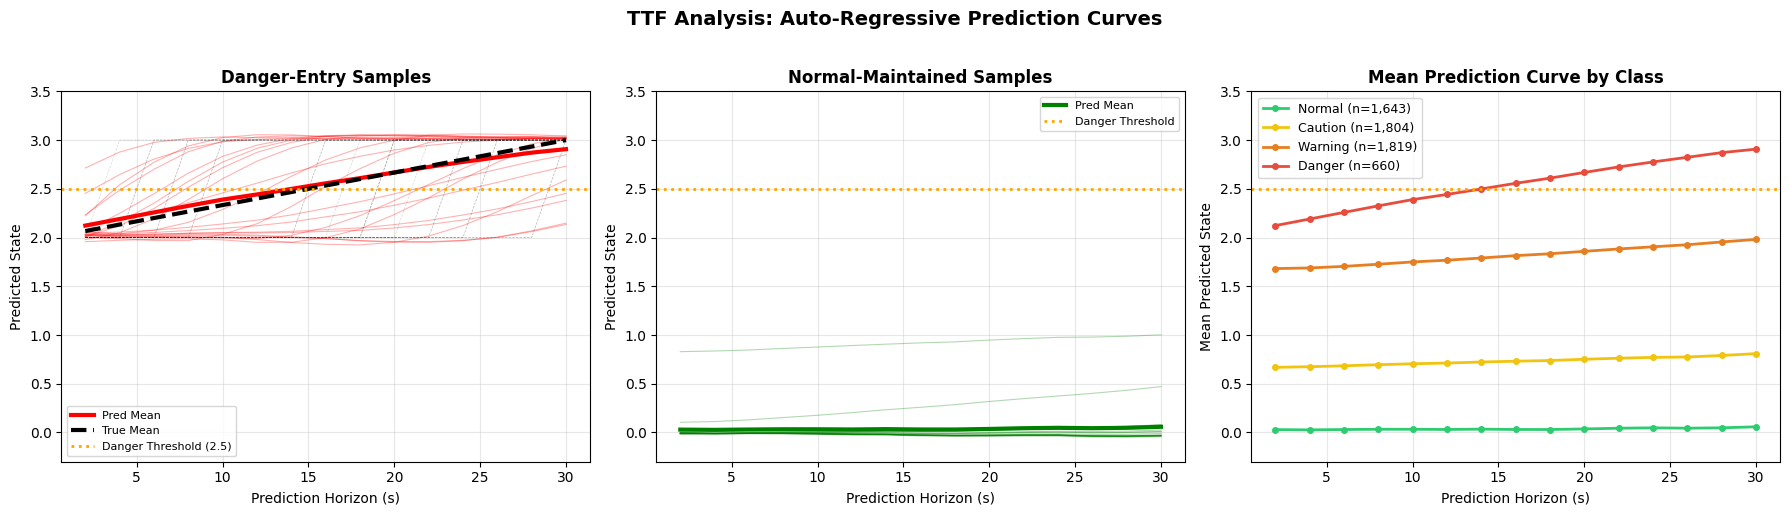

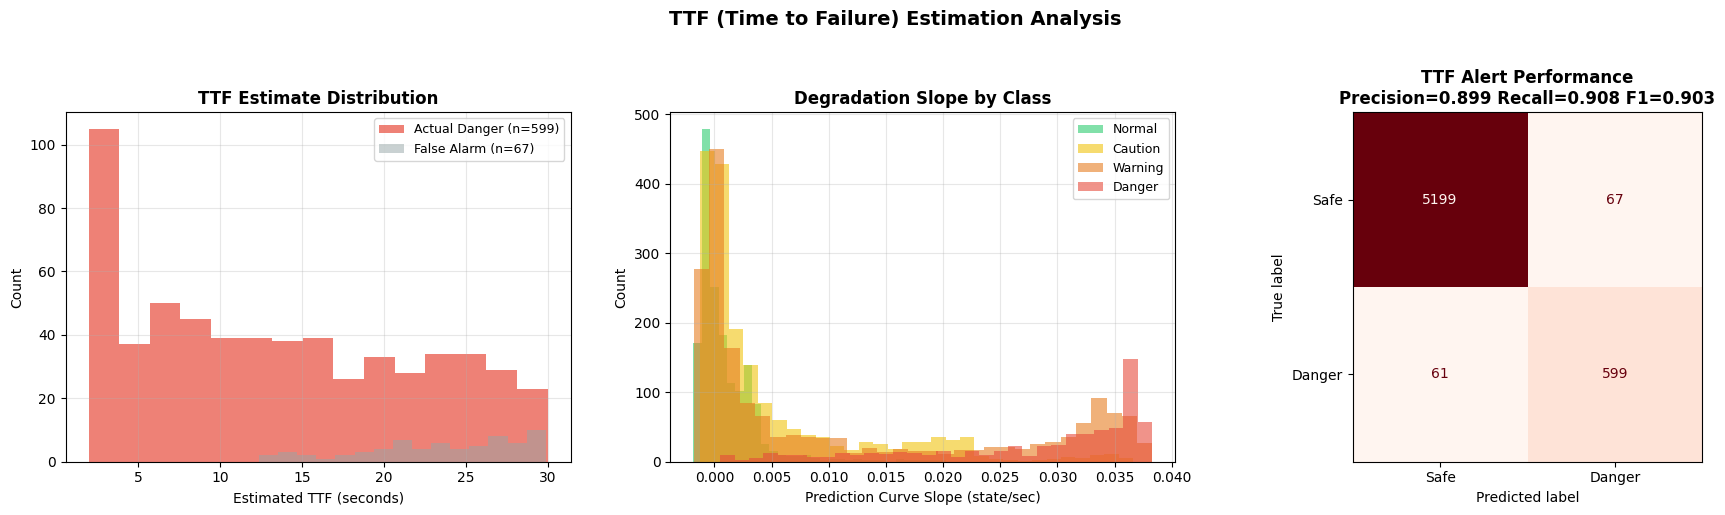

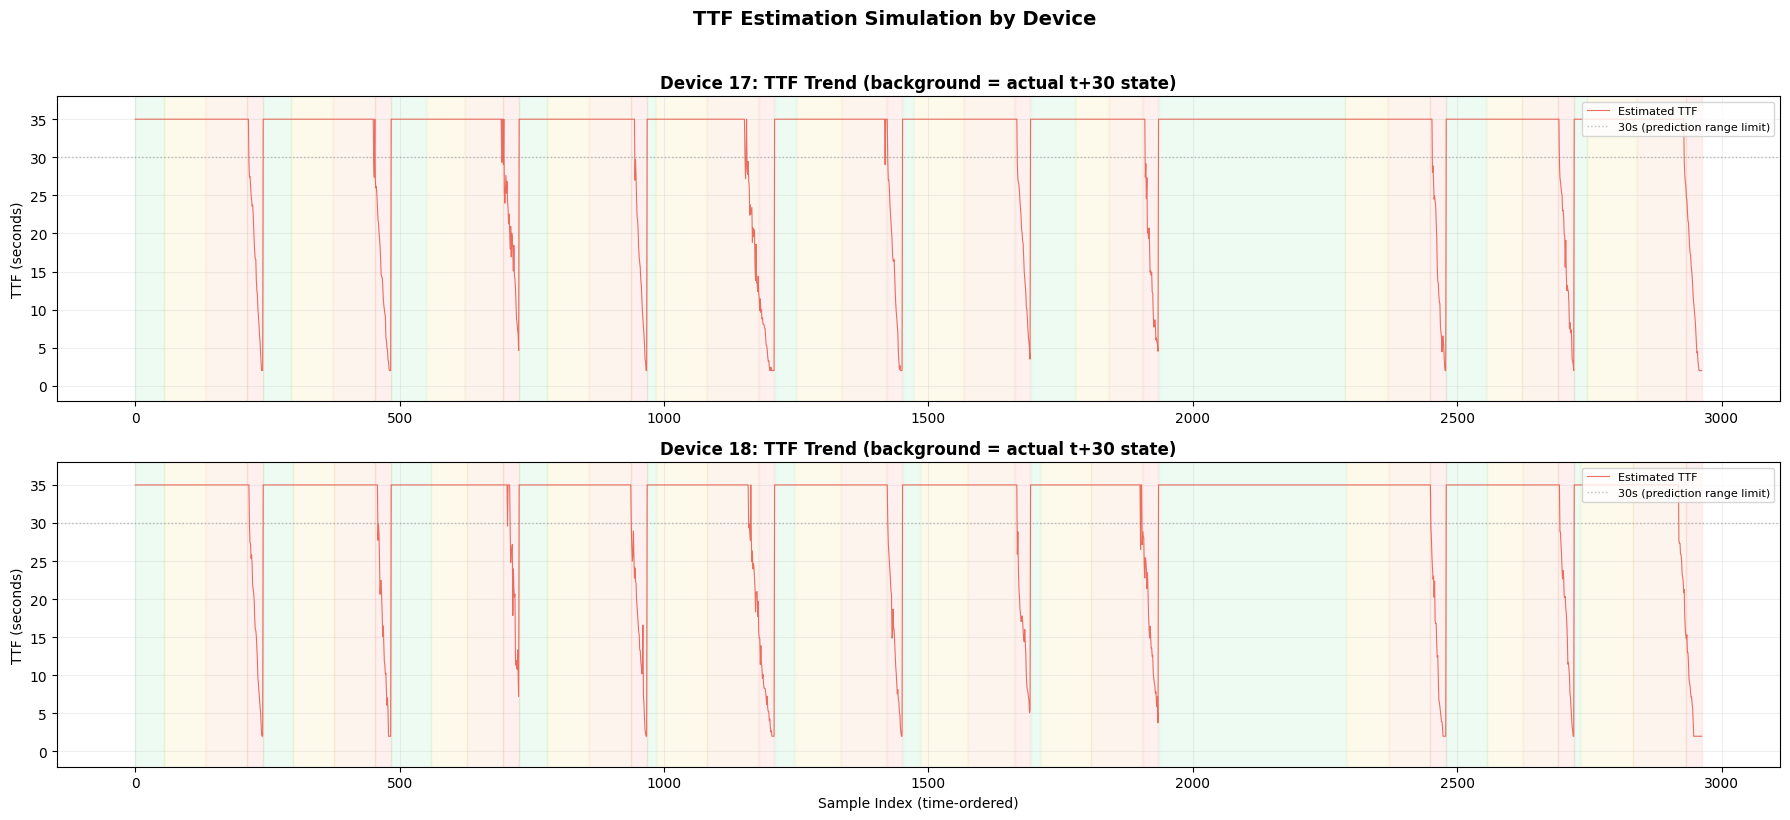

  TTF (Time to Failure) Estimation Summary

  [Model] Auto-Regressive MMT-B
  [Data]  Test (Device 17~18): 5,926 samples
  [Danger Threshold] 2.5 (pred >= 2.5 -> danger)

  [30s Danger Alert Accuracy]
  Precision: 0.8994
  Recall:    0.9076
  F1:        0.9035
  TP=599 / FP=67 / FN=61 / TN=5,199

  [TTF Distribution (actual danger samples)]
  Samples:    599
  Mean TTF:   13.4s
  Median TTF: 12.4s
  Range:      2.0 ~ 30.0s


In [ ]:
# ======================================================================
#  TTF (Time to Failure) 추정 가능성 분석 — 논문 5.6절
#
#  [핵심 아이디어]
#    다단계 예측 모델이 t+2 ~ t+30초의 연속 예측을 생성하므로,
#    이 "예측 곡선"을 분석하면:
#      1. 위험 등급(3)에 도달하는 예상 시점을 추정
#      2. 열화 추세의 기울기로 잔존 수명을 예측
#
#    이는 단순한 "현재 상태 분류"를 넘어
#    "언제 고장이 발생할 것인가"라는 실용적 질문에 답할 수 있음.
#
#  [분석 방법]
#    1. 예측 곡선 시각화: 위험 상태 진입 샘플의 예측 추이
#    2. TTF 추정: 예측값이 위험 임계값(2.5)을 넘는 첫 시점
#    3. 열화 기울기 분석: 예측 곡선의 1차 미분으로 열화 속도 추정
#    4. 조기 경보 시뮬레이션: TTF 기반 경보 발생 정확도
# ======================================================================

# Best AR 모델 사용 (논문에서 AR이 장기 예측에 우수)
ar_name = 'Auto-Regressive'
ar_result = ms_results[ar_name]
ar_preds  = ar_result['test_preds']     # [N, 15]
ar_labels = ar_result['test_labels']    # [N, 15]

DANGER_THRESHOLD = 2.5  # 위험 등급(3) 진입 판단 임계값
# 실제 등급은 정수(0,1,2,3)이지만, 회귀 예측이므로
# 2.5 이상이면 "위험 상태 진입 가능성 높음"으로 판단

# ======================================================================
#  1. 예측 곡선 시각화: 실제 위험 진입 샘플 vs 정상 유지 샘플
# ======================================================================

# 실제 t+30에서 Danger인 샘플 vs 끝까지 Normal인 샘플
danger_at_30 = ar_labels[:, 14].astype(int) == 3
normal_at_30 = ar_labels[:, 14].astype(int) == 0

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) 위험 진입 샘플의 예측 곡선 (랜덤 20개)
ax = axes[0]
danger_indices = np.where(danger_at_30)[0]
if len(danger_indices) > 20:
    chosen = np.random.choice(danger_indices, 20, replace=False)
else:
    chosen = danger_indices

for idx in chosen:
    ax.plot(PREDICTION_HORIZONS, ar_preds[idx], 'r-', alpha=0.3, linewidth=0.8)
    ax.plot(PREDICTION_HORIZONS, ar_labels[idx], 'k--', alpha=0.15, linewidth=0.5)

# 평균 곡선
if len(danger_indices) > 0:
    mean_pred = ar_preds[danger_indices].mean(axis=0)
    mean_true = ar_labels[danger_indices].mean(axis=0)
    ax.plot(PREDICTION_HORIZONS, mean_pred, 'r-', linewidth=3, label='Pred Mean')
    ax.plot(PREDICTION_HORIZONS, mean_true, 'k--', linewidth=3, label='True Mean')

ax.axhline(y=DANGER_THRESHOLD, color='orange', linestyle=':', linewidth=2,
           label=f'Danger Threshold ({DANGER_THRESHOLD})')
ax.set_xlabel('Prediction Horizon (s)')
ax.set_ylabel('Predicted State')
ax.set_title('Danger-Entry Samples', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.3, 3.5)

# (b) 정상 유지 샘플의 예측 곡선
ax = axes[1]
normal_indices = np.where(normal_at_30)[0]
if len(normal_indices) > 20:
    chosen = np.random.choice(normal_indices, 20, replace=False)
else:
    chosen = normal_indices

for idx in chosen:
    ax.plot(PREDICTION_HORIZONS, ar_preds[idx], 'g-', alpha=0.3, linewidth=0.8)

if len(normal_indices) > 0:
    mean_pred = ar_preds[normal_indices].mean(axis=0)
    ax.plot(PREDICTION_HORIZONS, mean_pred, 'g-', linewidth=3, label='Pred Mean')

ax.axhline(y=DANGER_THRESHOLD, color='orange', linestyle=':', linewidth=2,
           label='Danger Threshold')
ax.set_xlabel('Prediction Horizon (s)')
ax.set_ylabel('Predicted State')
ax.set_title('Normal-Maintained Samples', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.3, 3.5)

# (c) 전체 클래스별 평균 곡선 비교
ax = axes[2]
class_colors = {0: '#2ecc71', 1: '#f1c40f', 2: '#e67e22', 3: '#e74c3c'}
for cls in range(4):
    cls_mask = ar_labels[:, 14].astype(int) == cls
    if cls_mask.sum() > 0:
        mean_curve = ar_preds[cls_mask].mean(axis=0)
        ax.plot(PREDICTION_HORIZONS, mean_curve, '-o',
                color=class_colors[cls], linewidth=2, markersize=4,
                label=f'{STATE_MAP[cls]} (n={cls_mask.sum():,})')

ax.axhline(y=DANGER_THRESHOLD, color='orange', linestyle=':', linewidth=2)
ax.set_xlabel('Prediction Horizon (s)')
ax.set_ylabel('Mean Predicted State')
ax.set_title('Mean Prediction Curve by Class', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_ylim(-0.3, 3.5)

plt.suptitle('TTF Analysis: Auto-Regressive Prediction Curves',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  2. TTF 추정: 예측값이 위험 임계값을 넘는 첫 시점
# ======================================================================

def estimate_ttf(pred_curve, threshold=DANGER_THRESHOLD, horizons=PREDICTION_HORIZONS):
    """
    단일 샘플의 예측 곡선에서 TTF를 추정.

    예측값이 threshold를 넘는 첫 번째 시점을 TTF로 반환.
    넘지 않으면 None (아직 안전).

    Args:
        pred_curve: [15] 예측 곡선
        threshold:  위험 임계값 (기본 2.5)
        horizons:   시점 목록 [2, 4, ..., 30]

    Returns:
        ttf_seconds: 위험 진입까지 남은 시간 (초), 또는 None
    """
    for i, (pred_val, h) in enumerate(zip(pred_curve, horizons)):
        if pred_val >= threshold:
            # 선형 보간으로 더 정밀한 TTF 추정
            if i > 0:
                prev_val = pred_curve[i - 1]
                prev_h   = horizons[i - 1]
                ratio = (threshold - prev_val) / (pred_val - prev_val + 1e-8)
                ttf = prev_h + ratio * (h - prev_h)
            else:
                ttf = h
            return float(ttf)
    return None   # 30초 내 위험 도달하지 않음


# 전체 Test에 대한 TTF 추정
ttf_estimates = []
for i in range(len(ar_preds)):
    ttf = estimate_ttf(ar_preds[i])
    actual_cls_at_30 = int(ar_labels[i, 14])
    ttf_estimates.append({
        'idx': i,
        'ttf': ttf,
        'actual_state_t30': actual_cls_at_30,
        'is_danger': actual_cls_at_30 == 3,
        'curve_slope': (ar_preds[i, -1] - ar_preds[i, 0]) / (30 - 2),
    })

ttf_df = pd.DataFrame(ttf_estimates)

# ======================================================================
#  3. TTF 기반 조기 경보 정확도
# ======================================================================

# "위험 진입 예측" = TTF가 존재 (30초 내 위험 도달 예상)
ttf_df['predicted_danger'] = ttf_df['ttf'].notna()
ttf_df['actual_danger']    = ttf_df['is_danger']

# 분류 성능 (이진: 30초 후 위험 여부)
from sklearn.metrics import precision_score, accuracy_score

tp = ((ttf_df['predicted_danger']) & (ttf_df['actual_danger'])).sum()
fp = ((ttf_df['predicted_danger']) & (~ttf_df['actual_danger'])).sum()
fn = ((~ttf_df['predicted_danger']) & (ttf_df['actual_danger'])).sum()
tn = ((~ttf_df['predicted_danger']) & (~ttf_df['actual_danger'])).sum()

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall_d  = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_binary = 2 * precision * recall_d / (precision + recall_d) if (precision + recall_d) > 0 else 0

# TTF 분포 데이터 추출
danger_ttf     = ttf_df[ttf_df['actual_danger'] & ttf_df['predicted_danger']]['ttf']
non_danger_ttf = ttf_df[~ttf_df['actual_danger'] & ttf_df['predicted_danger']]['ttf']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) TTF 분포
ax = axes[0]
if len(danger_ttf) > 0:
    ax.hist(danger_ttf, bins=15, alpha=0.7, color='#e74c3c',
            label=f'Actual Danger (n={len(danger_ttf)})')
if len(non_danger_ttf) > 0:
    ax.hist(non_danger_ttf, bins=15, alpha=0.5, color='#95a5a6',
            label=f'False Alarm (n={len(non_danger_ttf)})')
ax.set_xlabel('Estimated TTF (seconds)')
ax.set_ylabel('Count')
ax.set_title('TTF Estimate Distribution', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (b) 열화 기울기 vs 실제 등급
ax = axes[1]
for cls in range(4):
    mask = ttf_df['actual_state_t30'] == cls
    if mask.sum() > 0:
        slopes = ttf_df[mask]['curve_slope']
        ax.hist(slopes, bins=30, alpha=0.6, color=class_colors[cls],
                label=f'{STATE_MAP[cls]}')
ax.set_xlabel('Prediction Curve Slope (state/sec)')
ax.set_ylabel('Count')
ax.set_title('Degradation Slope by Class', fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

# (c) 조기 경보 혼동 행렬
ax = axes[2]
cm = np.array([[tn, fp], [fn, tp]])
disp = ConfusionMatrixDisplay(cm, display_labels=['Safe', 'Danger'])
disp.plot(ax=ax, cmap='Reds', values_format='d', colorbar=False)
ax.set_title(f'TTF Alert Performance\nPrecision={precision:.3f} Recall={recall_d:.3f} F1={f1_binary:.3f}',
             fontweight='bold')

plt.suptitle('TTF (Time to Failure) Estimation Analysis',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  4. 시계열 TTF 시뮬레이션
#    실제 운용 시나리오: 장비 17, 18번의 시간 흐름에 따른 TTF 추이
# ======================================================================

fig, axes = plt.subplots(2, 1, figsize=(18, 8))

for plot_idx, target_dev in enumerate([17, 18]):
    ax = axes[plot_idx]
    dev_mask = np.array([w['device_num'] == target_dev for w in ms_test])

    if dev_mask.sum() == 0:
        ax.text(0.5, 0.5, f'Device {target_dev}: No data',
                ha='center', va='center', transform=ax.transAxes)
        continue

    dev_preds  = ar_preds[dev_mask]       # [n, 15]
    dev_labels = ar_labels[dev_mask]      # [n, 15]
    n_points = len(dev_preds)

    # t+30 실제 등급
    actual_t30 = dev_labels[:, 14].astype(int)

    # TTF 추정 (각 시점에서의 추정)
    dev_ttf = []
    for i in range(n_points):
        ttf = estimate_ttf(dev_preds[i])
        dev_ttf.append(ttf if ttf is not None else 35)  # None이면 35초(안전)

    dev_ttf = np.array(dev_ttf)
    x = np.arange(n_points)

    # 배경: 실제 t+30 등급
    for cls, color in class_colors.items():
        cls_mask = actual_t30 == cls
        if cls_mask.any():
            ax.fill_between(x, -5, 40, where=cls_mask, color=color, alpha=0.08)

    # TTF 추이
    ax.plot(x, dev_ttf, color='#e74c3c', linewidth=0.8, alpha=0.8, label='Estimated TTF')
    ax.axhline(y=30, color='gray', linestyle=':', linewidth=1, alpha=0.5,
               label='30s (prediction range limit)')

    ax.set_ylabel('TTF (seconds)')
    ax.set_title(f'Device {target_dev:02d}: TTF Trend (background = actual t+30 state)',
                 fontweight='bold')
    ax.set_ylim(-2, 38)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.2)

axes[-1].set_xlabel('Sample Index (time-ordered)')
plt.suptitle('TTF Estimation Simulation by Device',
             fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ======================================================================
#  5. 수치 요약 (빈 데이터 방어 포함)
# ======================================================================

print(f"{'='*65}")
print(f"  TTF (Time to Failure) Estimation Summary")
print(f"{'='*65}")
print(f"")
print(f"  [Model] Auto-Regressive MMT-B")
print(f"  [Data]  Test (Device 17~18): {len(ar_preds):,} samples")
print(f"  [Danger Threshold] {DANGER_THRESHOLD} (pred >= {DANGER_THRESHOLD} -> danger)")
print(f"")
print(f"  [30s Danger Alert Accuracy]")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall_d:.4f}")
print(f"  F1:        {f1_binary:.4f}")
print(f"  TP={tp:,} / FP={fp:,} / FN={fn:,} / TN={tn:,}")
print(f"")
print(f"  [TTF Distribution (actual danger samples)]")
if len(danger_ttf) > 0:
    print(f"  Samples:    {len(danger_ttf)}")
    print(f"  Mean TTF:   {danger_ttf.mean():.1f}s")
    print(f"  Median TTF: {danger_ttf.median():.1f}s")
    print(f"  Range:      {danger_ttf.min():.1f} ~ {danger_ttf.max():.1f}s")
else:
    print(f"  (No danger samples with TTF estimate — adjust threshold)")
print(f"{'='*65}")

# Reference

- [멀티모달 학습 기반 OHT 장비 열화 예측 연구](https://www.dbpia.co.kr/journal/articleDetail?nodeId=NODE12304100)